# 다변량 정규분포를 이용한 재현자료 척도 비교 

# 패키지 , 데이터 불러오기

In [87]:
import os
import pickle 
import sdv.metrics
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/HANBatang.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 평가척도를 위한 패키지 불러오기

In [89]:
from sdmetrics.single_column import KSComplement
from sdmetrics.column_pairs import CorrelationSimilarity
from sdmetrics.single_column import RangeCoverage
from sdmetrics.single_column import StatisticSimilarity
from sdmetrics.single_column import BoundaryAdherence
from sdmetrics.single_column import CSTest
from sdmetrics.single_table import NewRowSynthesis
from sdv.metadata import SingleTableMetadata # 싱글 메타 데이터의 경우에만! 멀티 메타 데이터의 경우에는 패키지를 다르게 불러와야함
from sdmetrics.reports.single_table import QualityReport 
from sdmetrics.reports.single_table import DiagnosticReport
from sdv.evaluation.single_table import evaluate_quality # Use this function to evaluate the quality of your synthetic data in terms of column shapes and correlations.
from sdv.evaluation.single_table import run_diagnostic # Check to see if the synthetic rows are pure copies of the real data
from sdv.evaluation.single_table import get_column_plot # Use this function to visualize a real column against the same synthetic column

# 서버에서 돌린 데이터 불러오기

In [96]:
path = "D:/Simulation Data/2023-09-10"

In [97]:
os.chdir(path)

In [98]:
dir_list = os.listdir(path)

In [99]:
print(dir_list)

['all_rho1_mvn.pkl', 'all_rho2_mvn.pkl', 'all_rho3_mvn.pkl', 'all_rho4_mvn.pkl', 'all_rho5_mvn.pkl', 'non_rho1_mvn.pkl', 'non_rho2_mvn.pkl', 'non_rho3_mvn.pkl', 'non_rho4_mvn.pkl', 'non_rho5_mvn.pkl', 'ori_all_rho1_data.pkl', 'ori_all_rho2_data.pkl', 'ori_all_rho3_data.pkl', 'ori_all_rho4_data.pkl', 'ori_all_rho5_data.pkl', 'ori_non_rho1_data.pkl', 'ori_non_rho2_data.pkl', 'ori_non_rho3_data.pkl', 'ori_non_rho4_data.pkl', 'ori_non_rho5_data.pkl']


In [94]:
def load_pickle(file_name) : 
    with open(file_name , 'rb') as f:
        return pickle.load(f)

### 경상소득(포함) 다변량 정규분포 불러오기

In [119]:
all_rho1_mvn = load_pickle(dir_list[0])
all_rho2_mvn = load_pickle(dir_list[1])
all_rho3_mvn = load_pickle(dir_list[2])
all_rho4_mvn = load_pickle(dir_list[3])
all_rho5_mvn = load_pickle(dir_list[4])

### 경상소득(미포함) 다변량 정규분포 불러오기

In [10]:
non_rho1_mvn = load_pickle(dir_list[5])
non_rho2_mvn = load_pickle(dir_list[6])
non_rho3_mvn = load_pickle(dir_list[7])
non_rho4_mvn = load_pickle(dir_list[8])
non_rho5_mvn = load_pickle(dir_list[9])

### 경상소득(포함) 다변량 정규분포의 재현자료 불러오기

In [117]:
ori_all_rho1_data = load_pickle(dir_list[10])
ori_all_rho2_data = load_pickle(dir_list[11])
ori_all_rho3_data = load_pickle(dir_list[12])
ori_all_rho4_data = load_pickle(dir_list[13])
ori_all_rho5_data = load_pickle(dir_list[14])

### 경상소득(미포함) 다변량 정규분포 재현자료 불러오기

In [12]:
ori_non_rho1_data = load_pickle(dir_list[15])
ori_non_rho2_data = load_pickle(dir_list[16])
ori_non_rho3_data = load_pickle(dir_list[17])
ori_non_rho4_data = load_pickle(dir_list[18])
ori_non_rho5_data = load_pickle(dir_list[19])

### 미포함 자료에 대한 경상소득(조사) 열 만들기

In [20]:
def sum_income(data) : 
    
    for i in range(500):
        data[i]['경상소득(조사)'] = data[i].iloc[:,1:6].sum(axis = 1)
        

In [21]:
sum_income(non_rho1_mvn)
sum_income(non_rho2_mvn)
sum_income(non_rho3_mvn)
sum_income(non_rho4_mvn)
sum_income(non_rho5_mvn)

In [22]:
sum_income(ori_non_rho1_data)
sum_income(ori_non_rho2_data)
sum_income(ori_non_rho3_data)
sum_income(ori_non_rho4_data)
sum_income(ori_non_rho5_data)

## 편차 구해주고 평균 , 표준편차 구해주고 데이터프레임으로 만들어주는 함수

In [183]:
def unbiased(variable, synthetic_data, mvn_data, iteration):
    
    diffs = np.zeros((iteration, 7))  

    for i in range(iteration):
        diffs[i, 0] = synthetic_data[i][variable].mean() - mvn_data[i][variable].mean()
        diffs[i, 1] = synthetic_data[i][variable].std() - mvn_data[i][variable].std()
        diffs[i, 2] = np.quantile(synthetic_data[i][variable], q=0.25) - np.quantile(mvn_data[i][variable], q=0.25)
        diffs[i, 3] = np.quantile(synthetic_data[i][variable], q=0.50) - np.quantile(mvn_data[i][variable], q=0.50)
        diffs[i, 4] = np.quantile(synthetic_data[i][variable], q=0.75) - np.quantile(mvn_data[i][variable], q=0.75)
        diffs[i, 5] = np.quantile(synthetic_data[i][variable], q=0.90) - np.quantile(mvn_data[i][variable], q=0.90)
        diffs[i, 6] = np.quantile(synthetic_data[i][variable], q=0.99) - np.quantile(mvn_data[i][variable], q=0.99)

    # 평균과 표준편차 계산
    mean_diff = np.mean(diffs, axis=0)
    std_diff = np.std(diffs, axis=0)

    # 결과 DataFrame 생성
    result = pd.DataFrame({'Bias의 평균': mean_diff, 'Bias의 표준편차': std_diff},
                          index=['평균', '표준편차', '25%', '50%', '75%', '90%', '99%'])
    
    return result


### 경상소득(조사) 포함 안된 것에 대한 데이터프레임

In [186]:
a1 = unbiased('경상소득(조사)' , ori_non_rho1_data , non_rho1_mvn , 500)
a2 = unbiased('경상소득(조사)' , ori_non_rho2_data , non_rho2_mvn , 500)
a3 = unbiased('경상소득(조사)' , ori_non_rho3_data , non_rho3_mvn , 500)
a4 = unbiased('경상소득(조사)' , ori_non_rho4_data , non_rho4_mvn , 500)
a5 = unbiased('경상소득(조사)' , ori_non_rho5_data , non_rho5_mvn , 500)

In [187]:
pd.concat([a1,a2,a3,a4,a5] , axis = 1)

Bias의 평균   Bias의 표준편차     Bias의 평균   Bias의 표준편차     Bias의 평균  \
평균    -41.007708  1149.865637    59.002676  1187.833223    20.554816   
표준편차 -200.260110   320.279417 -1122.665722   308.833087 -1938.164901   
25%   210.541059  1179.252282   919.084464  1209.978491  1432.495383   
50%   -39.531812  1116.573788    58.062049  1169.186782    21.773976   
75%  -297.093620  1146.968383  -806.909027  1207.562129 -1391.885682   
90%  -383.430903  1250.700284 -1447.798692  1289.711356 -2531.129366   
99%  -172.162892  1474.052886 -2255.770190  1457.073460 -4199.196186   

       Bias의 표준편차     Bias의 평균   Bias의 표준편차     Bias의 평균   Bias의 표준편차  
평균    1160.849392   -59.786713  1136.589536    92.617448  1432.680580  
표준편차   304.549910 -2688.367793   311.287427 -3253.410625   341.923800  
25%   1182.086013  1844.069996  1187.965239  2364.205949  1496.141524  
50%   1150.017937   -61.691165  1143.469686   102.230737  1526.236044  
75%   1177.927359 -1962.330284  1144.576412 -2171.620385  1501.502798  
90%   1264.013870 -3564.949841  1202.937742 -4132.493223  1450.551266  
99%   1485.799012 -6073.982875  1376.938775 -7288.312239  1407.452454

### 경상소득(조사) 포함 된 것에 대한 데이터프레임

In [188]:
b1 = unbiased('경상소득(조사)' , ori_all_rho1_data , all_rho1_mvn , 500)
b2 = unbiased('경상소득(조사)' , ori_all_rho2_data , all_rho2_mvn , 500)
b3 = unbiased('경상소득(조사)' , ori_all_rho3_data , all_rho3_mvn , 500)
b4 = unbiased('경상소득(조사)' , ori_all_rho4_data , all_rho4_mvn , 500)
b5 = unbiased('경상소득(조사)' , ori_all_rho5_data , all_rho5_mvn , 500)

In [189]:
pd.concat([b1,b2,b3,b4,b5] , axis = 1)

Bias의 평균   Bias의 표준편차     Bias의 평균   Bias의 표준편차     Bias의 평균  \
평균      28.847919  1322.818842   -33.993415  1235.460318   -64.439466   
표준편차   385.253094   405.799920   325.800947   399.020728   278.297133   
25%    141.873375  1339.355502    83.617898  1301.791035   104.152801   
50%     45.552819  1165.407403   -38.501221  1098.985978   -35.434773   
75%    -60.943367  1389.795471  -163.433539  1243.335658  -222.495708   
90%    312.118744  1673.474971   193.299304  1546.091545    71.773578   
99%   1716.793836  1891.862649  1563.810080  1906.322362  1361.946444   

       Bias의 표준편차     Bias의 평균   Bias의 표준편차     Bias의 평균   Bias의 표준편차  
평균    1154.118856    -0.868907  1037.630185    12.507617   949.928058  
표준편차   411.894399   269.647549   391.878919   247.981906   321.347346  
25%   1226.165481   115.194570  1116.031816   137.588889  1043.245729  
50%   1026.582946   -20.519055   986.073287     6.388249  1019.804643  
75%   1152.322833  -145.574056  1107.488651  -110.881303  1088.774895  
90%   1390.523227   195.788654  1302.881515   187.145966  1116.540678  
99%   1746.593236  1429.602060  1645.642730  1261.329299  1165.008023

## 상자그림 한꺼번에 보여주는 함수 (평균 ,표준편차 , 25% , 50% , 75% , 90% , 99%)

## 수정한 함수

### 검정통계량 모두 모아놓기

경상소득(조사) 열을 모아놓은 

In [293]:
def ori_statistic_result(variable, iteration):
    
    data_result = [] 

    for i in range(1, 6):
        
        original = eval(f'all_rho{i}_mvn')
        synthetic = eval(f'ori_all_rho{i}_data') 
        
        mean_original = []
        mean_syndata = []
        std_original = []
        std_syndata = []
        qu_ori_25 = []
        qu_syn_25 = []
        qu_ori_50 = []
        qu_syn_50 = []
        qu_ori_75 = []
        qu_syn_75 = []
        qu_ori_90 = []
        qu_syn_90 = []
        qu_ori_99 = []
        qu_syn_99 = []

        for j in range(iteration):
                        
            mean_original.append(np.mean(original[j][variable]))
            mean_syndata.append(np.mean(synthetic[j][variable]))
            std_original.append(np.std(original[j][variable]))
            std_syndata.append(np.std(synthetic[j][variable]))
            qu_ori_25.append(np.quantile(original[j][variable], q=0.25))
            qu_syn_25.append(np.quantile(synthetic[j][variable], q=0.25))
            qu_ori_50.append(np.quantile(original[j][variable], q=0.50))
            qu_syn_50.append(np.quantile(synthetic[j][variable], q=0.50))
            qu_ori_75.append(np.quantile(original[j][variable], q=0.75))
            qu_syn_75.append(np.quantile(synthetic[j][variable], q=0.75))
            qu_ori_90.append(np.quantile(original[j][variable], q=0.90))
            qu_syn_90.append(np.quantile(synthetic[j][variable], q=0.90))
            qu_ori_99.append(np.quantile(original[j][variable], q=0.99))
            qu_syn_99.append(np.quantile(synthetic[j][variable], q=0.99))
        
        result = pd.DataFrame({'mean_original': mean_original,'mean_syndata': mean_syndata,'std_original': std_original,'std_syndata': std_syndata,
            'qu_ori_25': qu_ori_25,'qu_syn_25': qu_syn_25,'qu_ori_50': qu_ori_50,'qu_syn_50': qu_syn_50,'qu_ori_75': qu_ori_75,'qu_syn_75': qu_syn_75,
            'qu_ori_90': qu_ori_90,'qu_syn_90': qu_syn_90,'qu_ori_99': qu_ori_99,'qu_syn_99': qu_syn_99,})
        
        data_result.append(result)
            
    return data_result

In [294]:
def ori_non_statistic_result(variable, iteration):
    
    data_result = [] 

    for i in range(1, 6):
        
        original = eval(f'non_rho{i}_mvn')
        synthetic = eval(f'ori_non_rho{i}_data') 
        
        mean_original = []
        mean_syndata = []
        std_original = []
        std_syndata = []
        qu_ori_25 = []
        qu_syn_25 = []
        qu_ori_50 = []
        qu_syn_50 = []
        qu_ori_75 = []
        qu_syn_75 = []
        qu_ori_90 = []
        qu_syn_90 = []
        qu_ori_99 = []
        qu_syn_99 = []

        for j in range(iteration):
                        
            mean_original.append(np.mean(original[j][variable]))
            mean_syndata.append(np.mean(synthetic[j][variable]))
            std_original.append(np.std(original[j][variable]))
            std_syndata.append(np.std(synthetic[j][variable]))
            qu_ori_25.append(np.quantile(original[j][variable], q=0.25))
            qu_syn_25.append(np.quantile(synthetic[j][variable], q=0.25))
            qu_ori_50.append(np.quantile(original[j][variable], q=0.50))
            qu_syn_50.append(np.quantile(synthetic[j][variable], q=0.50))
            qu_ori_75.append(np.quantile(original[j][variable], q=0.75))
            qu_syn_75.append(np.quantile(synthetic[j][variable], q=0.75))
            qu_ori_90.append(np.quantile(original[j][variable], q=0.90))
            qu_syn_90.append(np.quantile(synthetic[j][variable], q=0.90))
            qu_ori_99.append(np.quantile(original[j][variable], q=0.99))
            qu_syn_99.append(np.quantile(synthetic[j][variable], q=0.99))
        
        result = pd.DataFrame({'mean_original': mean_original,'mean_syndata': mean_syndata,'std_original': std_original,'std_syndata': std_syndata,
            'qu_ori_25': qu_ori_25,'qu_syn_25': qu_syn_25,'qu_ori_50': qu_ori_50,'qu_syn_50': qu_syn_50,'qu_ori_75': qu_ori_75,'qu_syn_75': qu_syn_75,
            'qu_ori_90': qu_ori_90,'qu_syn_90': qu_syn_90,'qu_ori_99': qu_ori_99,'qu_syn_99': qu_syn_99,})
        
        data_result.append(result)
            
    return data_result

### 상관계수마다 모든 통계량 박스플랏 보여주는 방식

In [285]:
def all_boxplot(statistic_data) : 
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.rcParams['font.size'] = 10
    fig, ax = plt.subplots()  
    label = statistic_data.columns
    ax.boxplot(statistic_data , labels = label)
    ax.set_xlabel('Data Type')
    ax.set_ylabel('Value')
    plt.title('statistic_boxplot')  # 선택한 통계량에 따라 그래프 제목 설정
    plt.show()

In [295]:
original = ori_statistic_result(variable = "경상소득(조사)" , iteration = 500)
original_non = ori_non_statistic_result(variable = "경상소득(조사)" , iteration = 500)

### 경상소득이 포함되지 않은 자료에 대한 상자그림

#### $\rho$ = 0.1

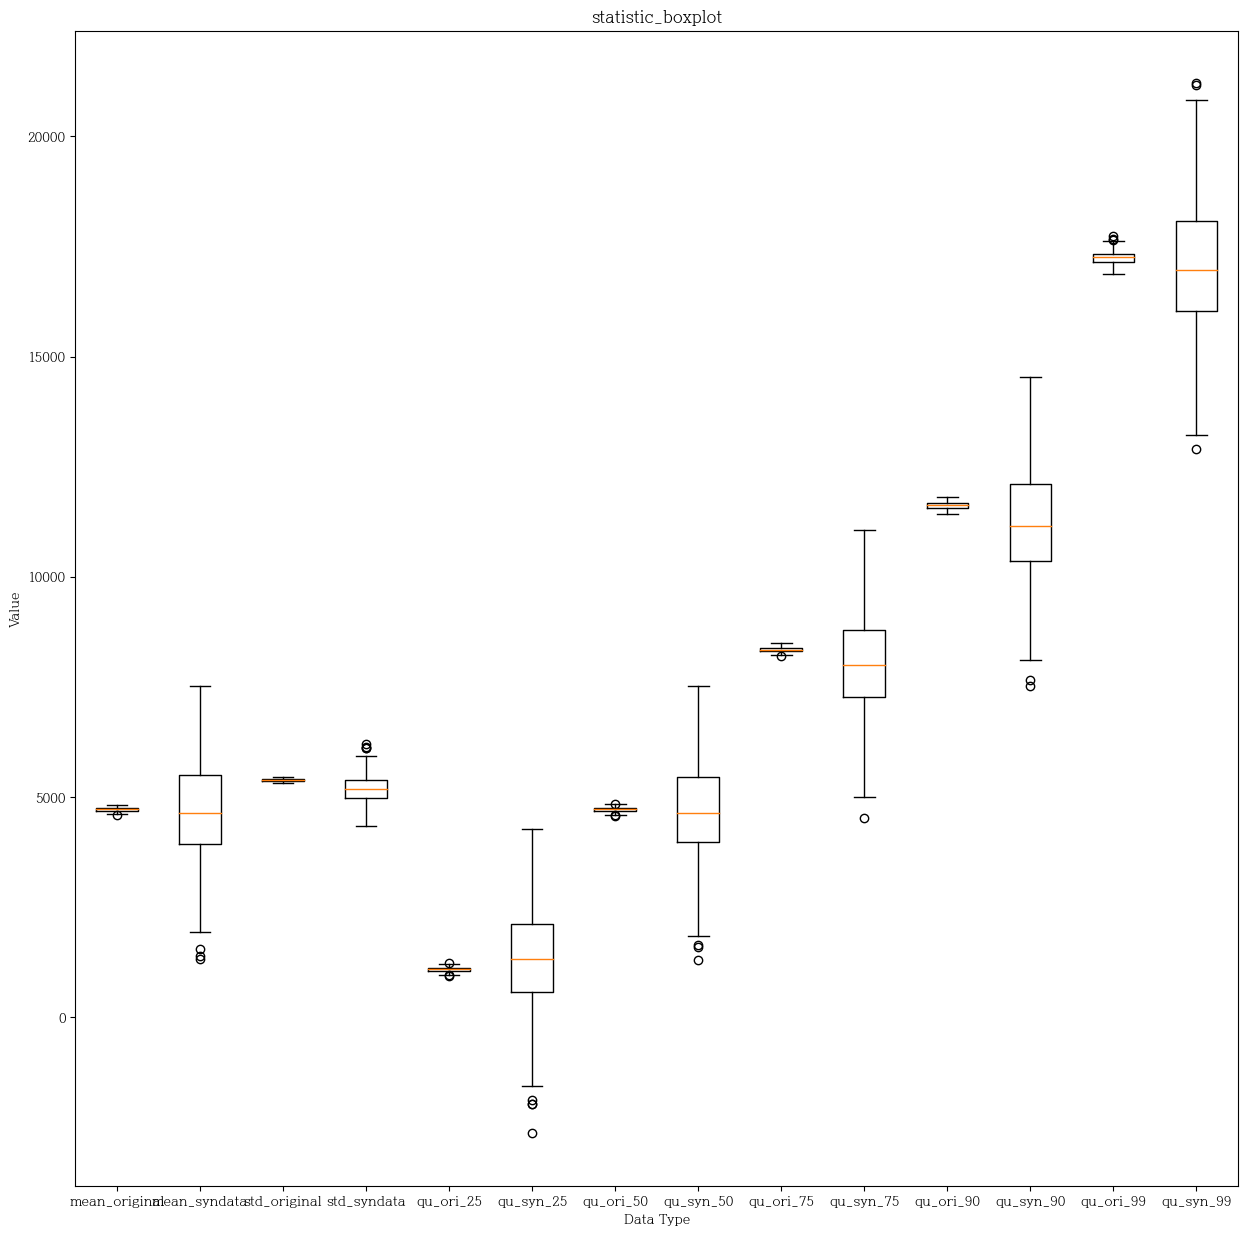

In [297]:
all_boxplot(original_non[0])

#### $\rho$ = 0.3

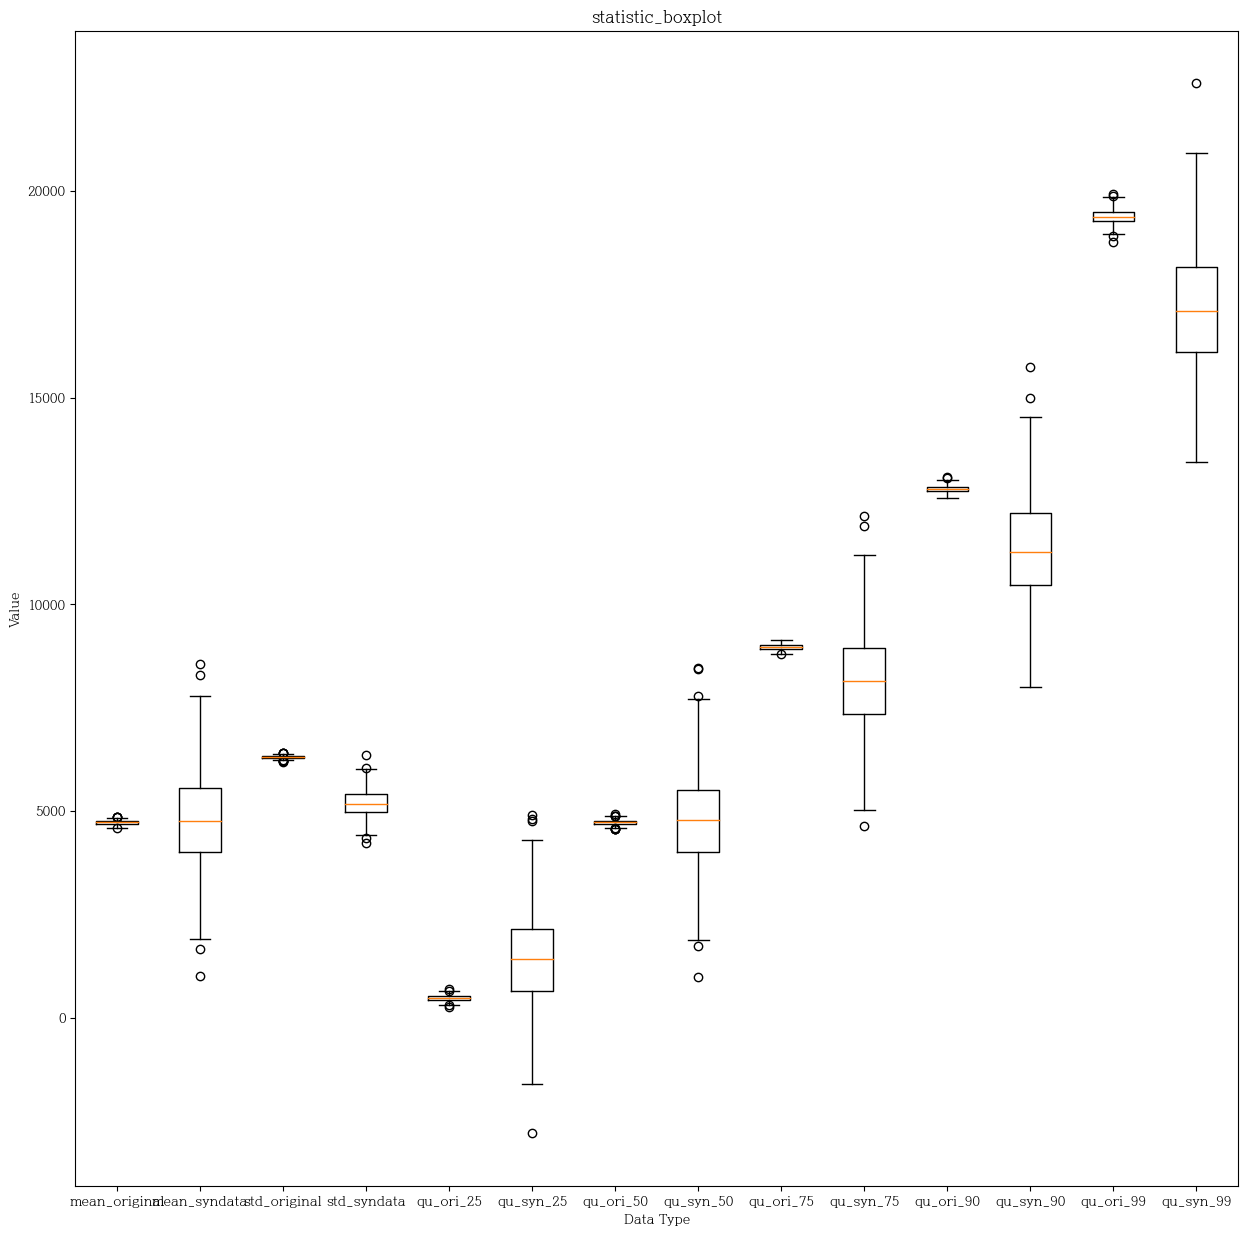

In [298]:
all_boxplot(original_non[1])

#### $\rho$ = 0.5

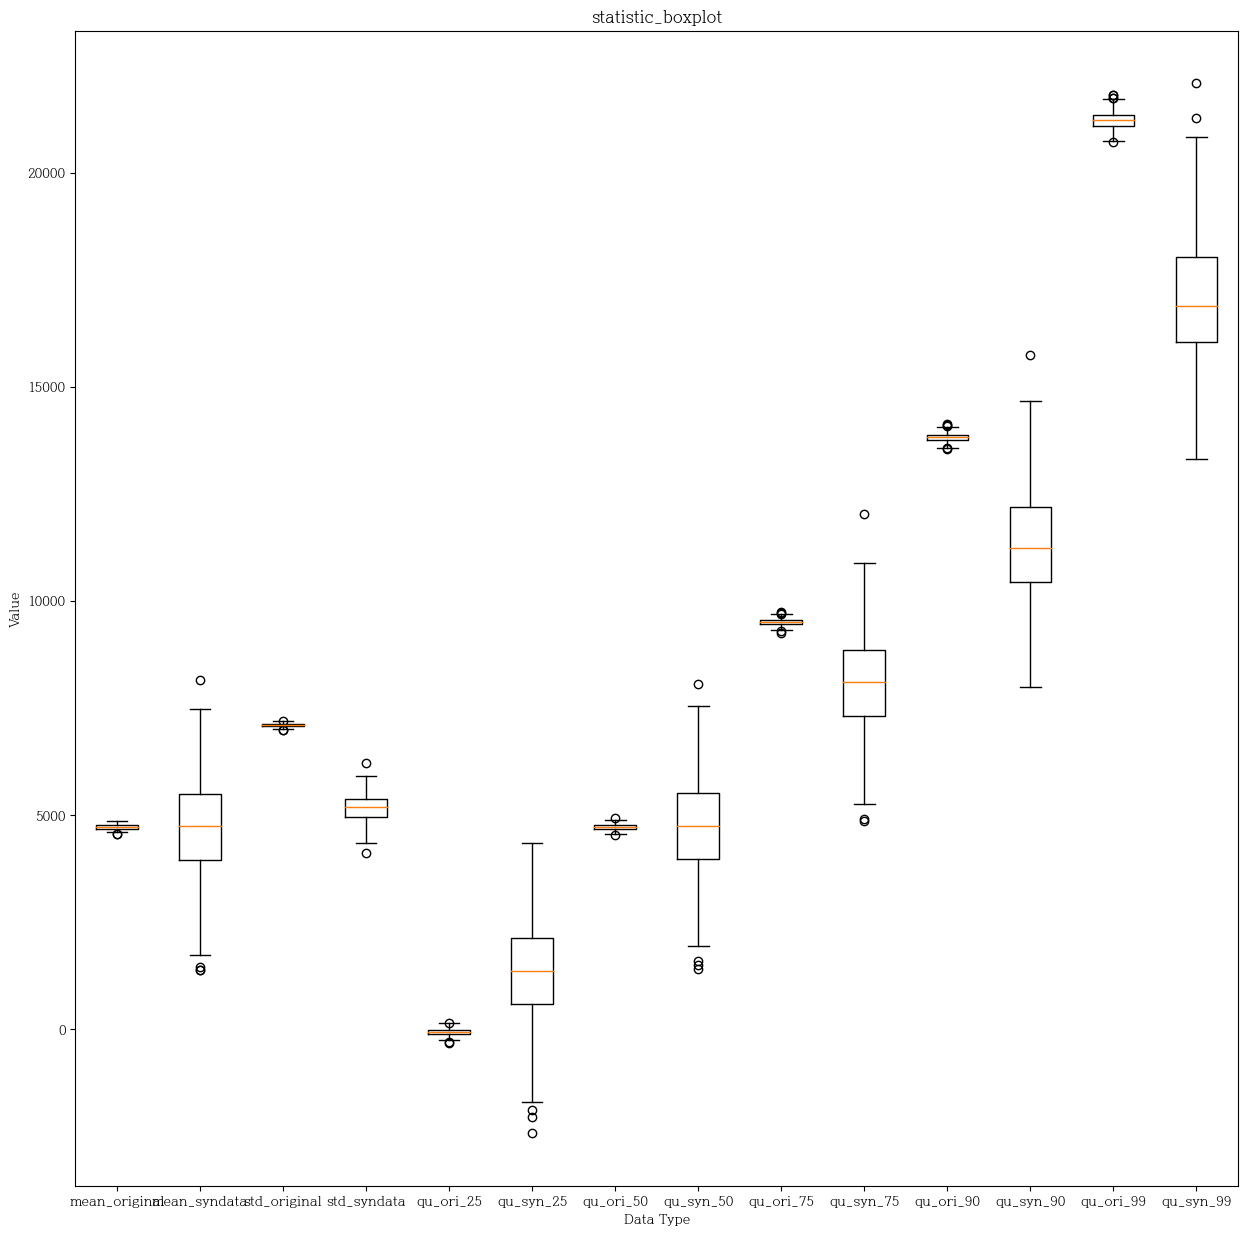

In [299]:
all_boxplot(original_non[2])

#### $\rho$ = 0.7

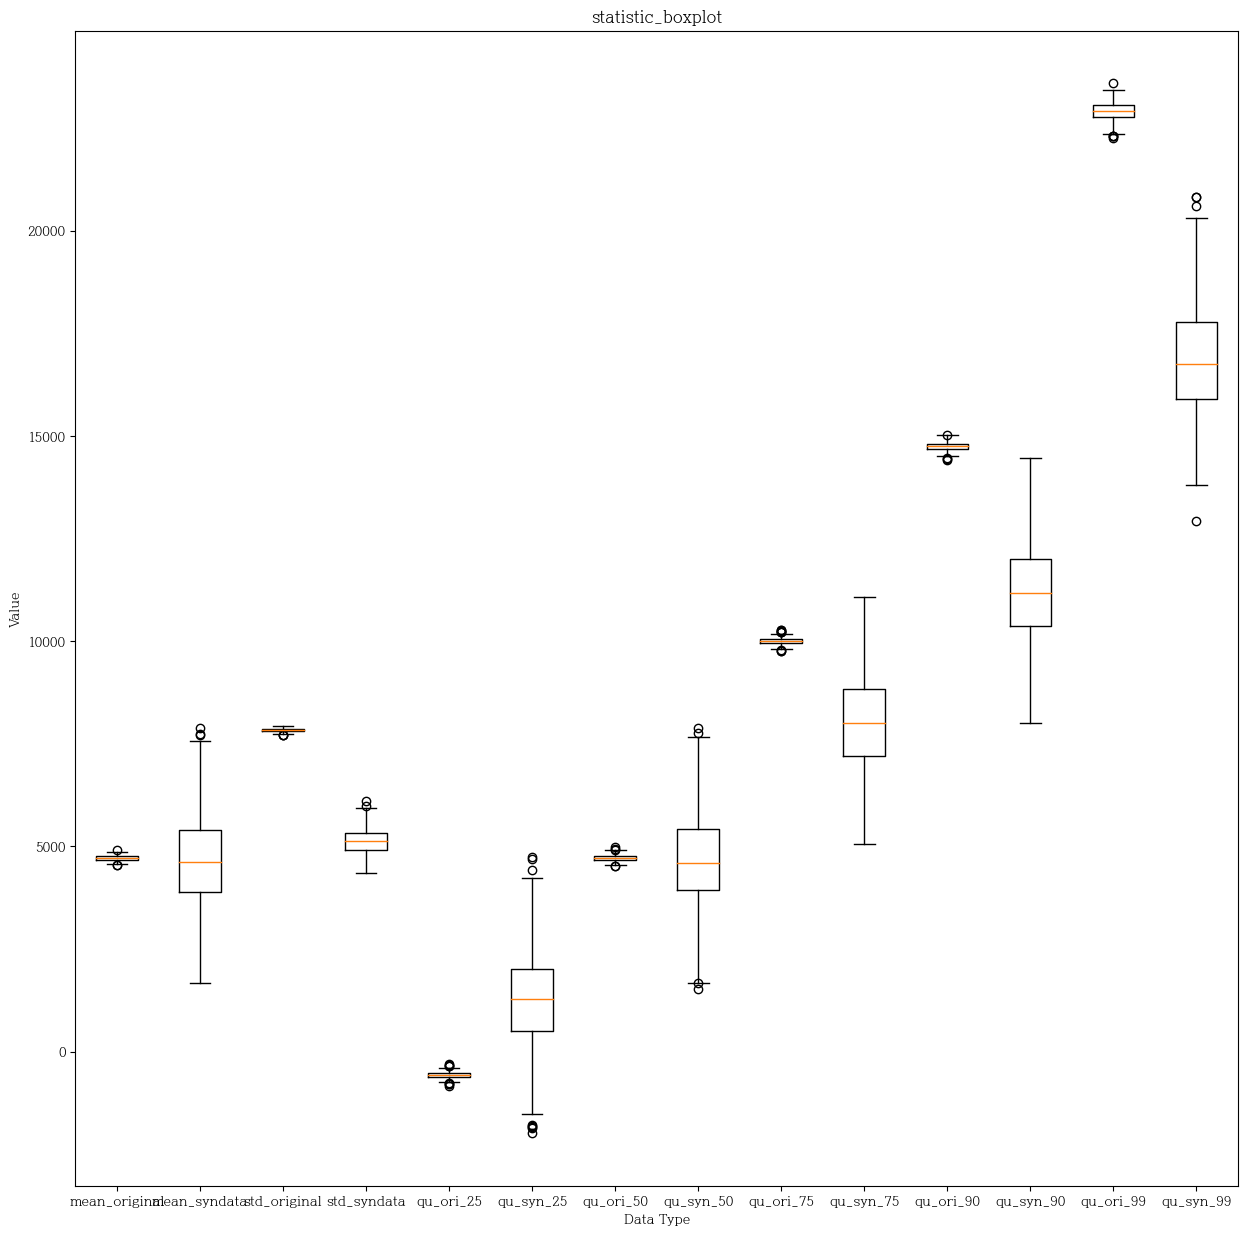

In [300]:
all_boxplot(original_non[3])

#### $\rho$ = 0.9

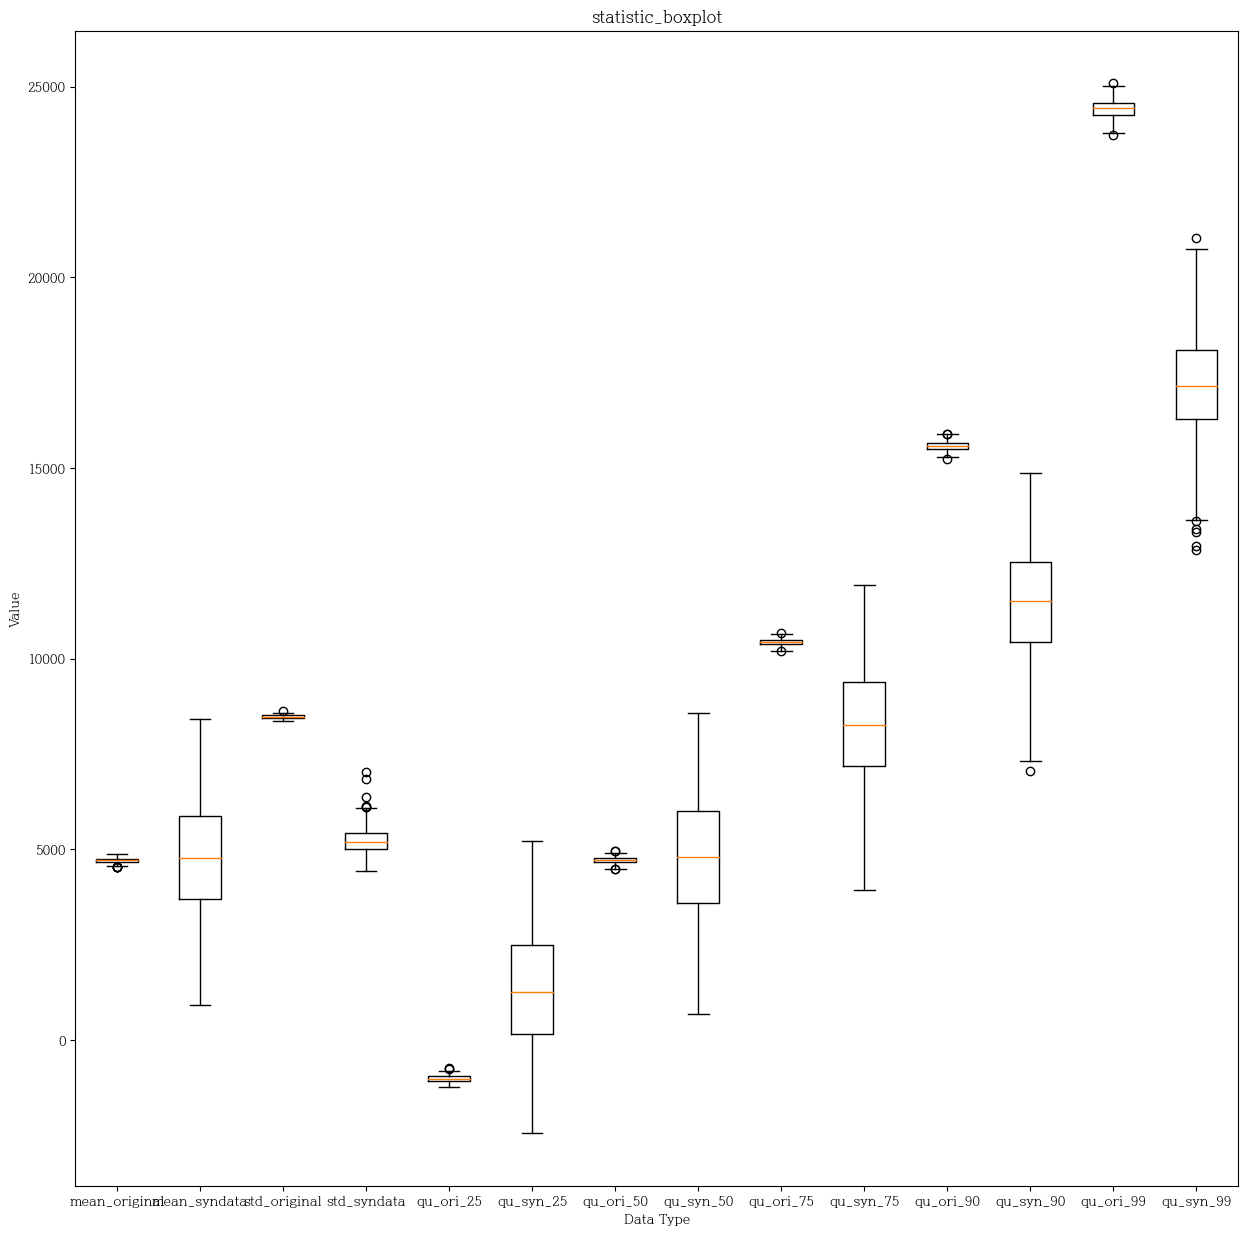

In [301]:
all_boxplot(original_non[4])

### 경상소득이 포함된 자료에 대한 상자그림

#### $\rho$ = 0.1

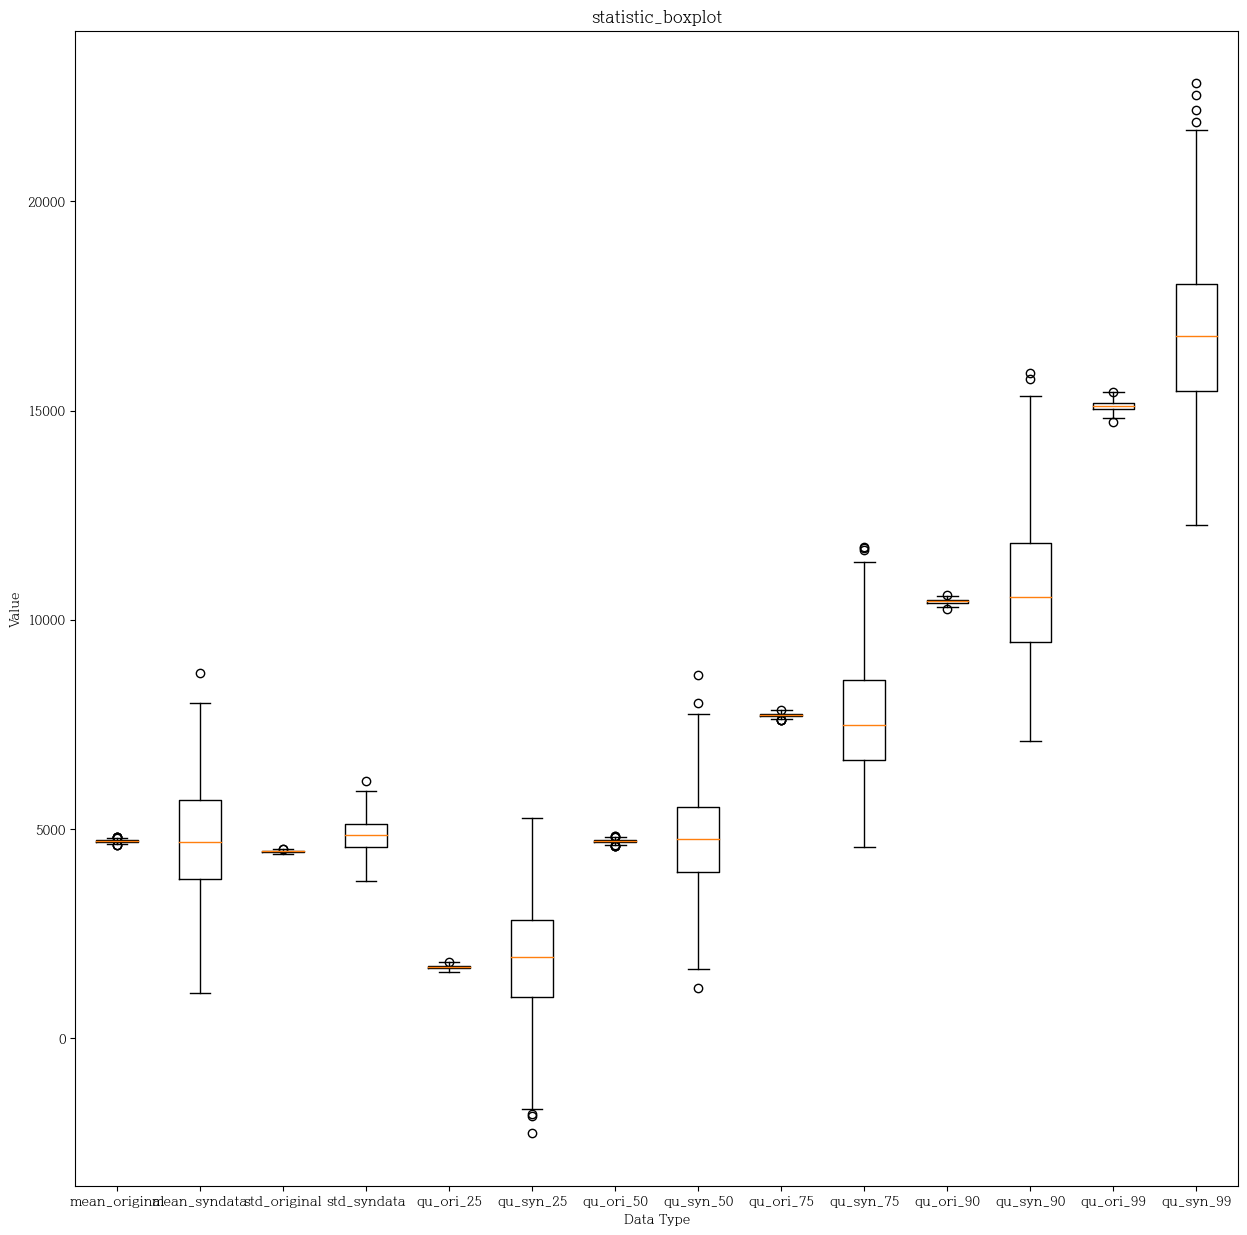

In [302]:
all_boxplot(original[0])

#### $\rho$ = 0.3

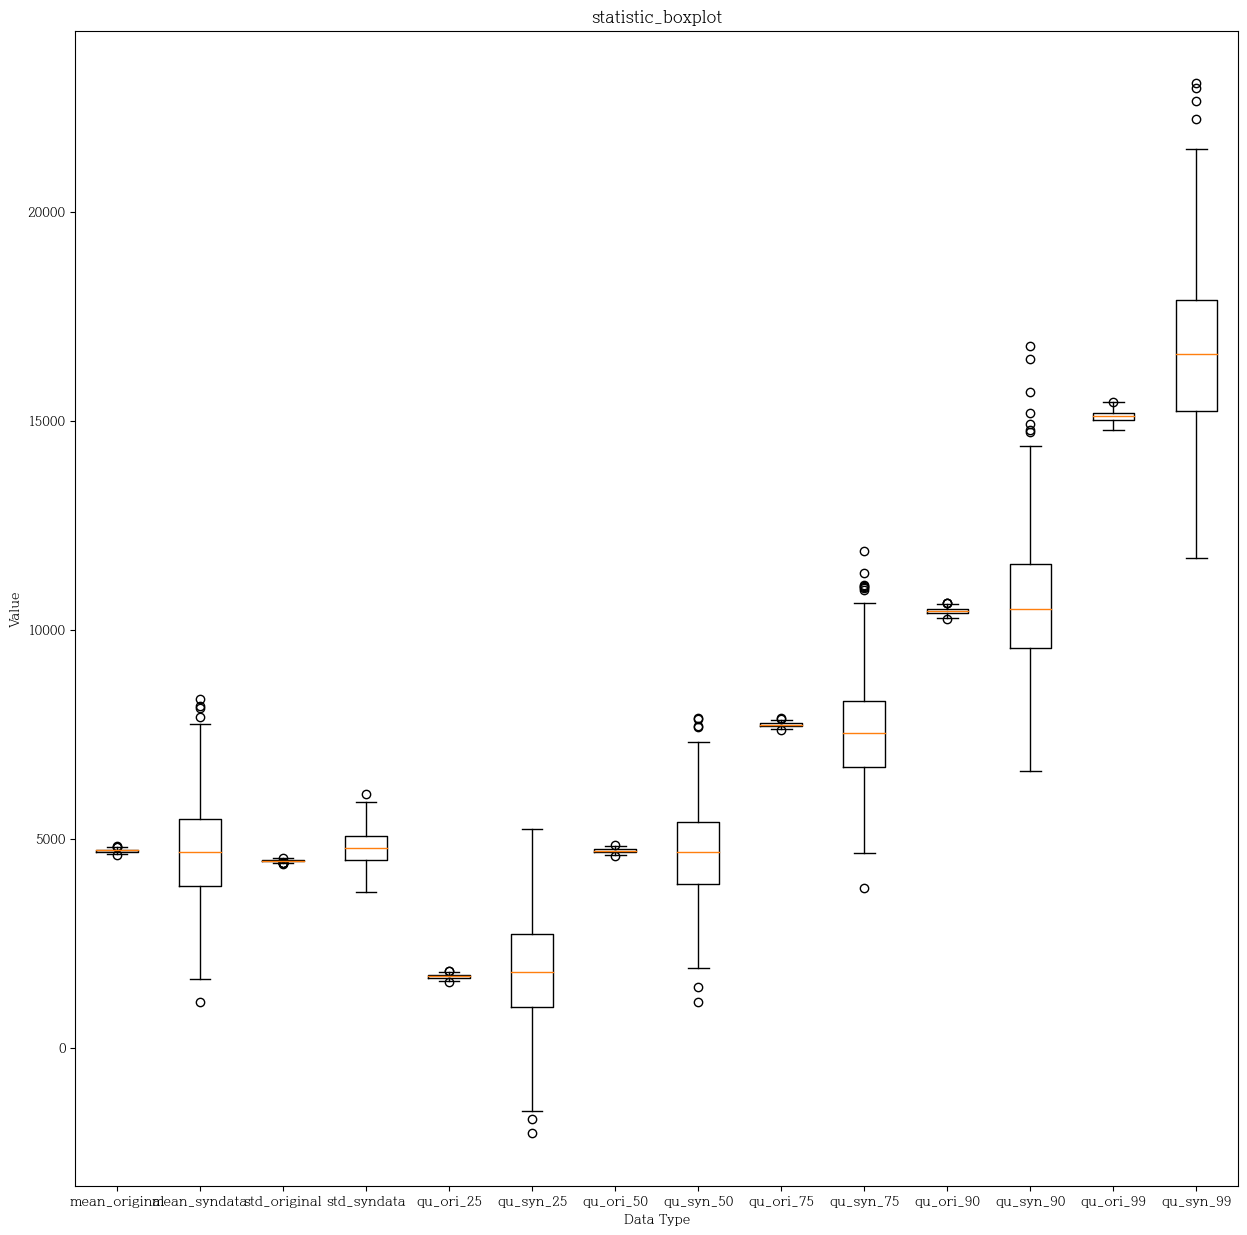

In [303]:
all_boxplot(original[1])

#### $\rho$ = 0.5

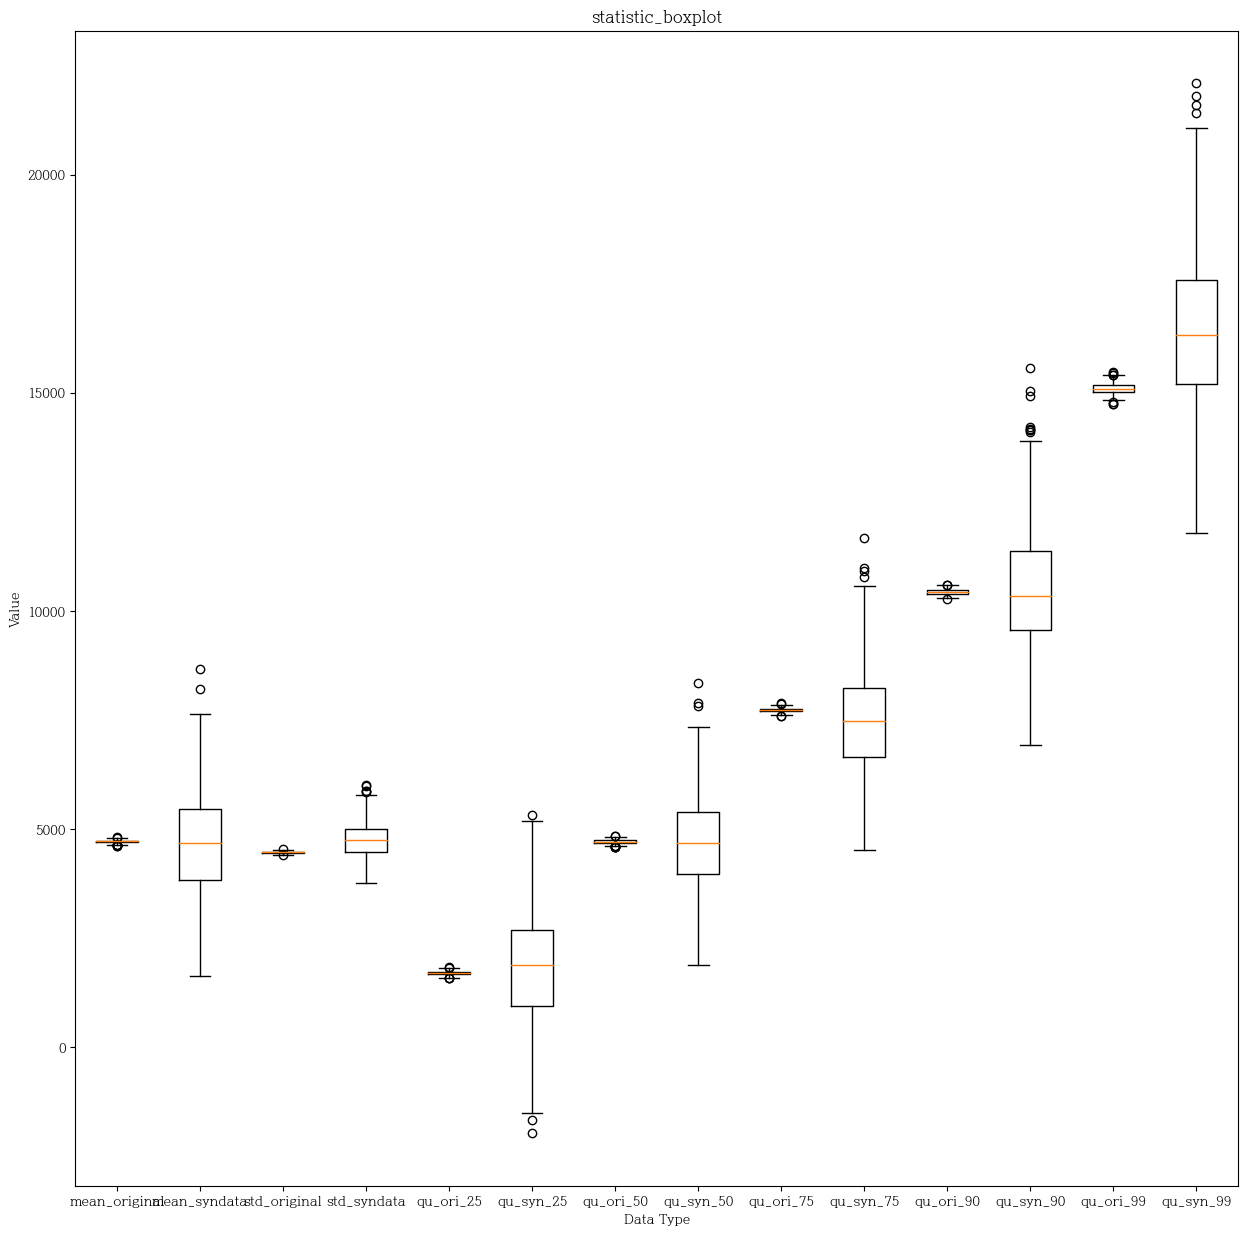

In [304]:
all_boxplot(original[2])

#### $\rho$ = 0.7

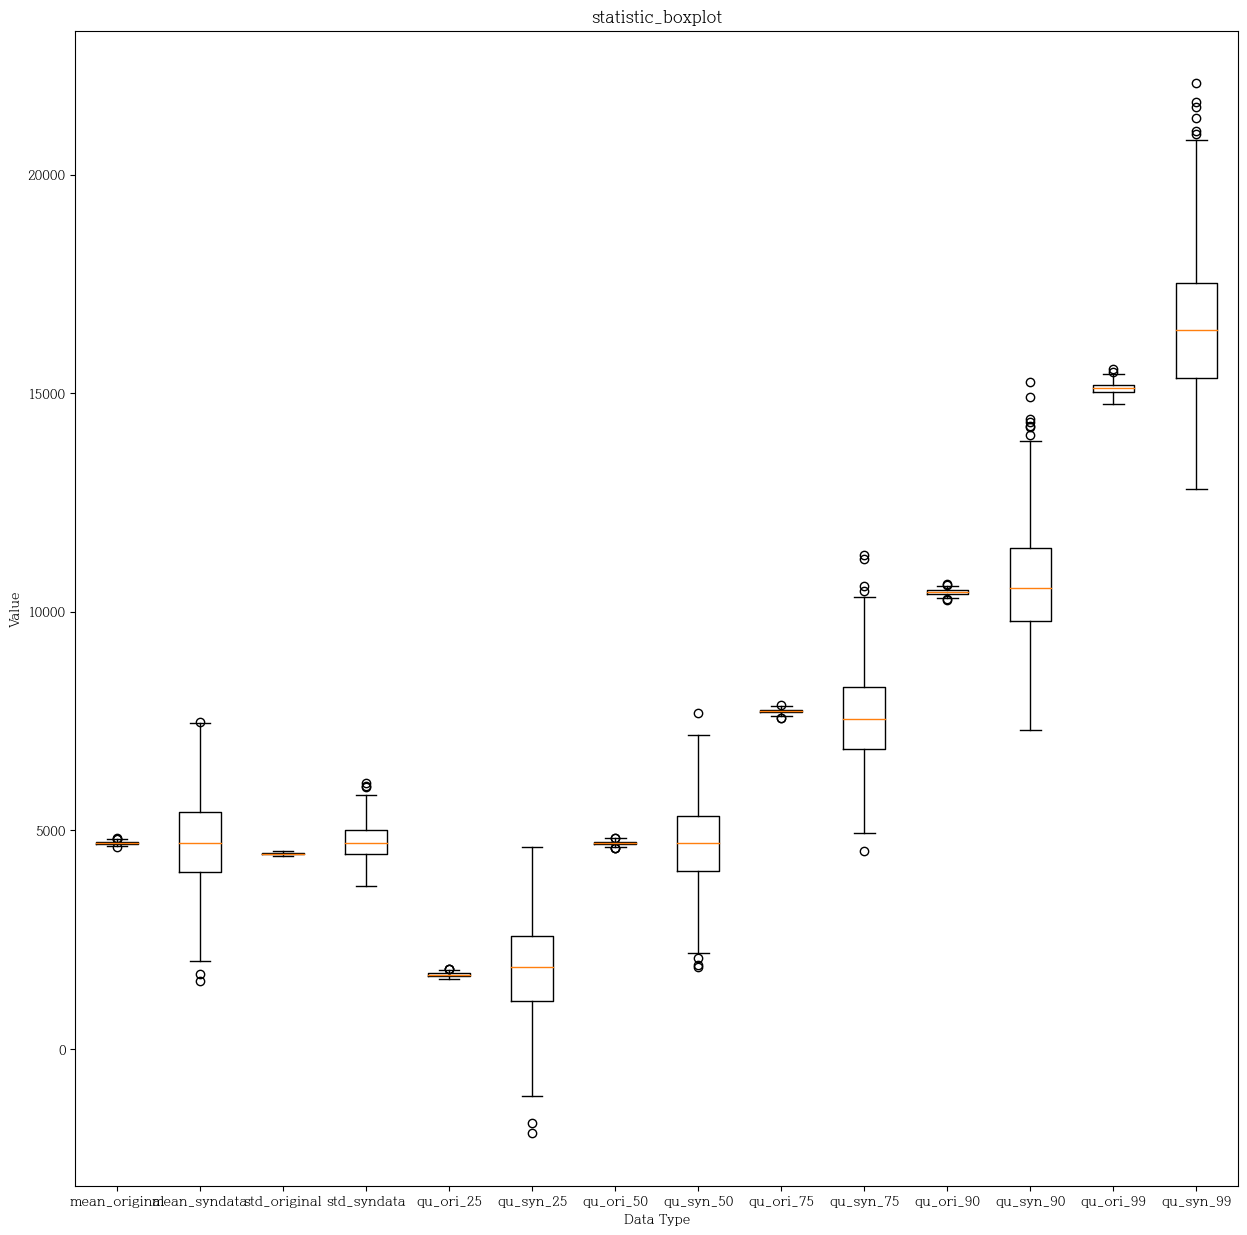

In [305]:
all_boxplot(original[3])

#### $\rho$ = 0.9

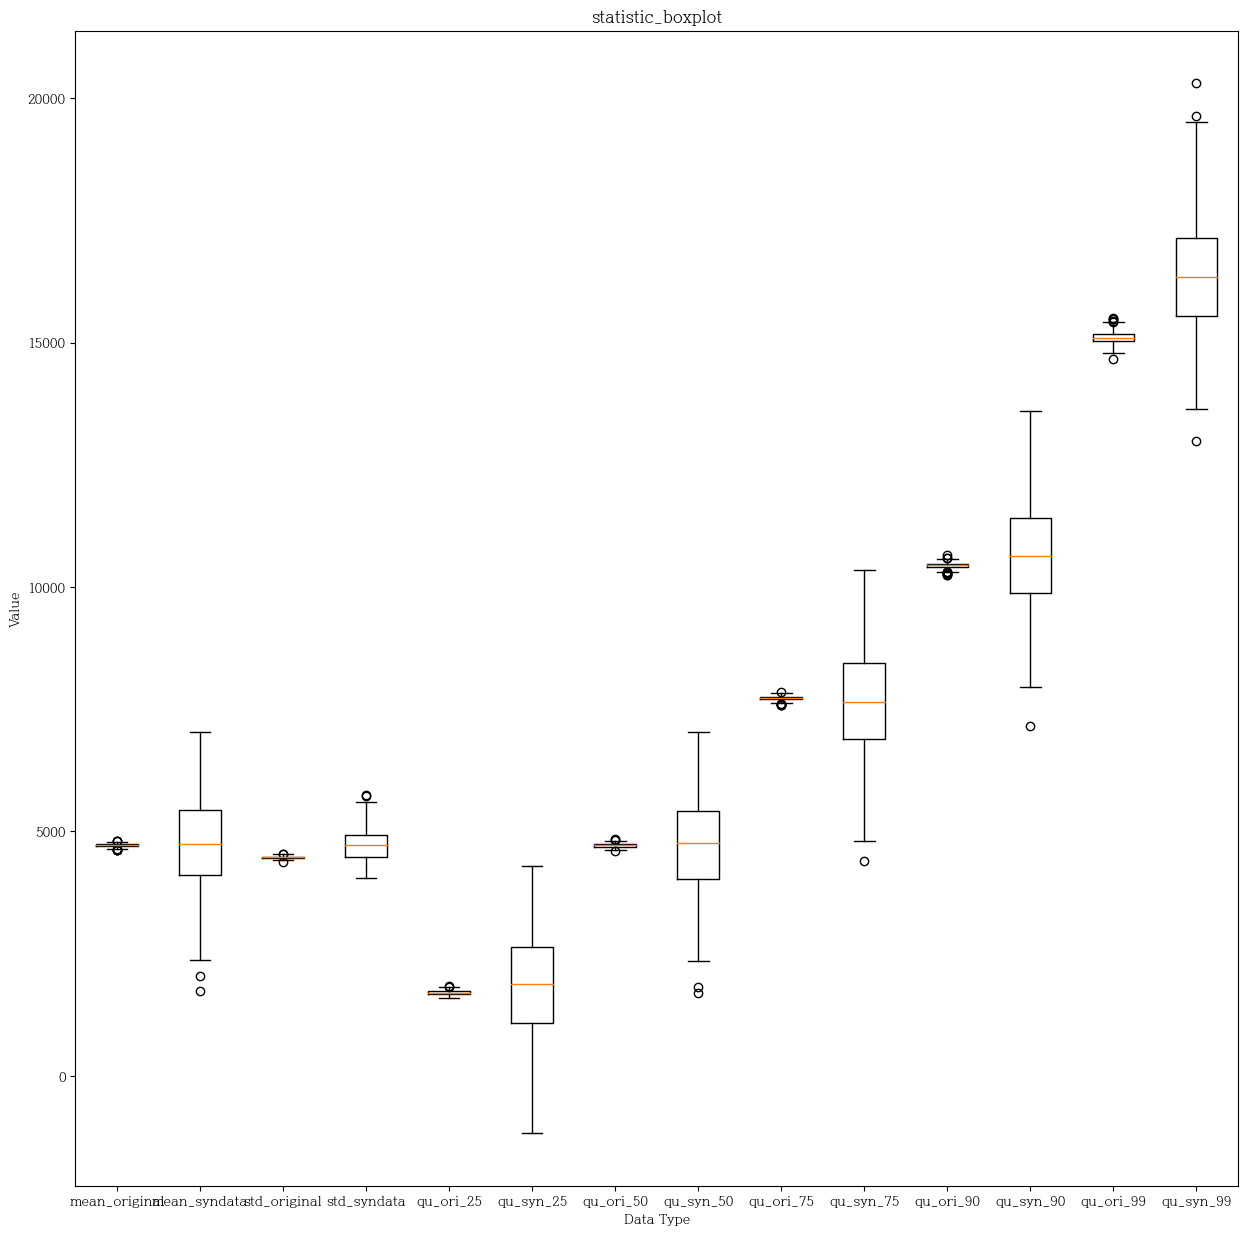

In [306]:
all_boxplot(original[4])

### 그래프 일대일로 겹처서 그리기 ( 첫번째 시뮬레이션 결과에 대해서 )

In [146]:
def one_by_scatter(data1 , data2 , variable1 , variable2):
        
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 10
    fig, ax = plt.subplots()
    
    plt.scatter(data1[variable1], data1[variable2] , color = 'purple' , alpha = 0.5 , label = '원자료')
    plt.scatter(data2[variable1], data2[variable2] , color = 'orange' , alpha = 0.3 , label = "재현자료")
    plt.legend()
    ax.set_xlabel(variable1)
    ax.set_ylabel(variable2)
    plt.title('plot')  # 선택한 통계량에 따라 그래프 제목 설정
    plt.show()

### 경상소득이 포함되지 않은 자료에 대한 그래프

#### $\rho$ = 0.1

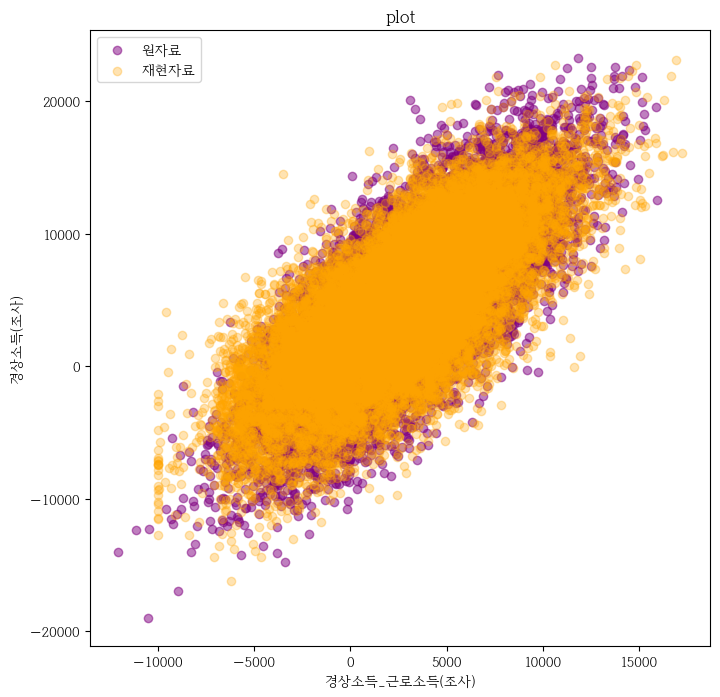

In [147]:
one_by_scatter(non_rho1_mvn[0] , ori_non_rho1_data[0] ,'경상소득_근로소득(조사)' ,  '경상소득(조사)' )

#### $\rho$ = 0.3

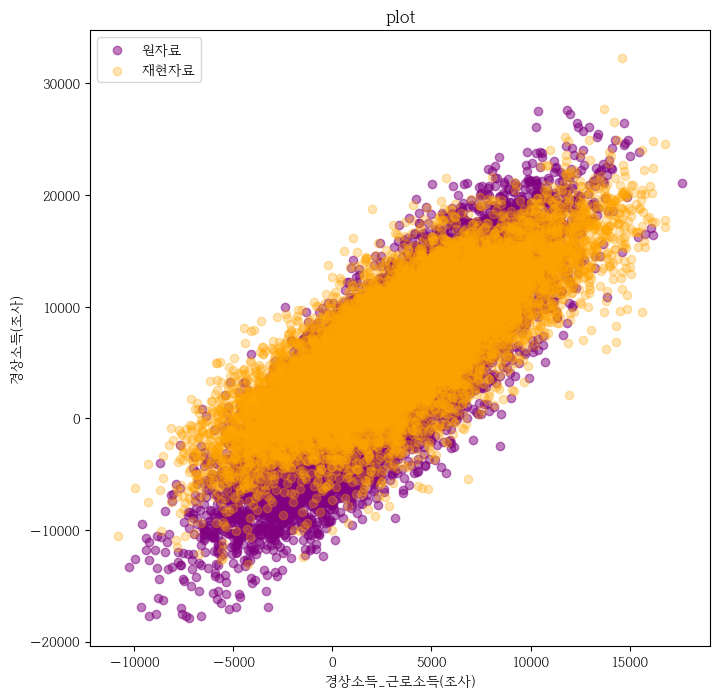

In [148]:
one_by_scatter(non_rho2_mvn[0] , ori_non_rho2_data[0] , '경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.5

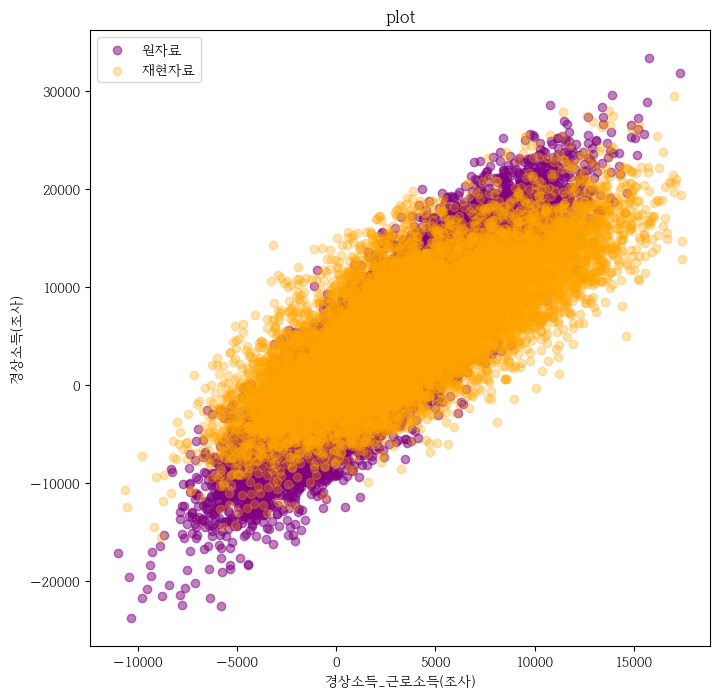

In [149]:
one_by_scatter(non_rho3_mvn[0] , ori_non_rho3_data[0] , '경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.7

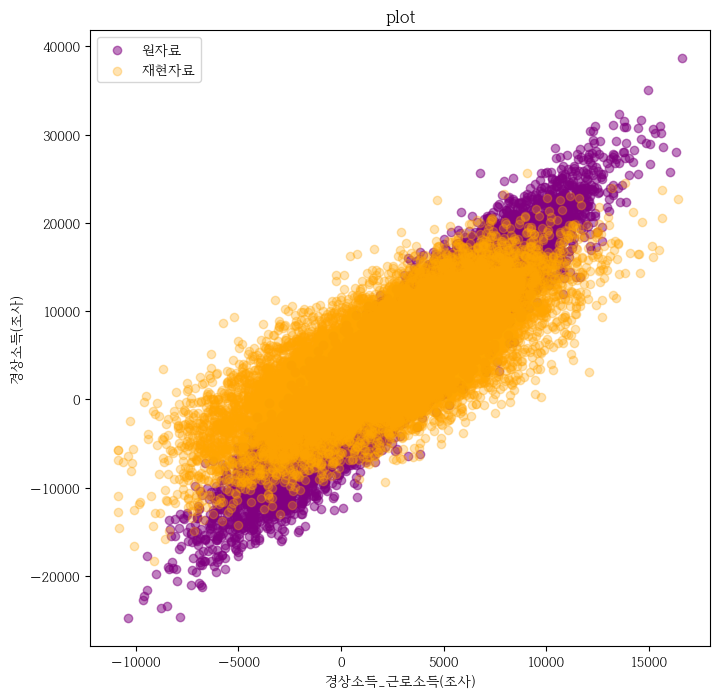

In [150]:
one_by_scatter(non_rho4_mvn[0] , ori_non_rho4_data[0] , '경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.9

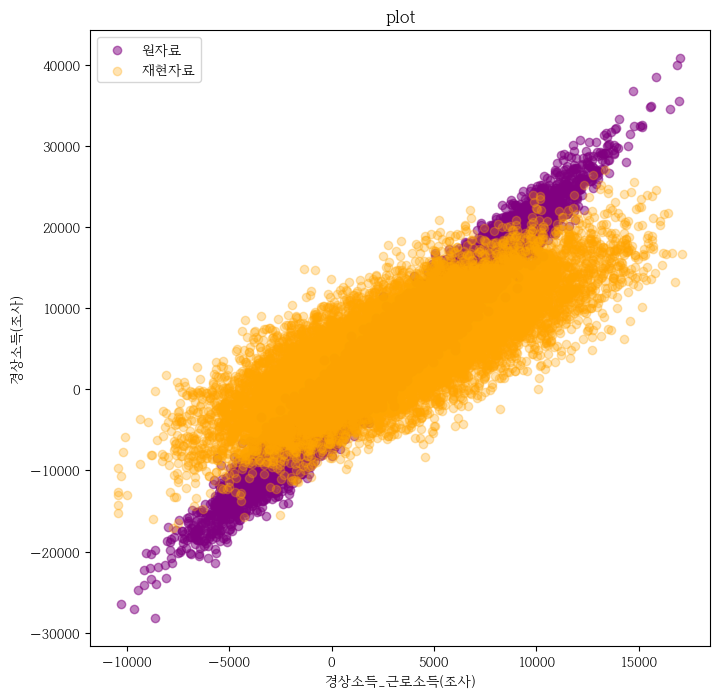

In [151]:
one_by_scatter(non_rho5_mvn[0] , ori_non_rho5_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

### 경상소득이 포함된 자료에 대한 그래프

#### $\rho$ = 0.1

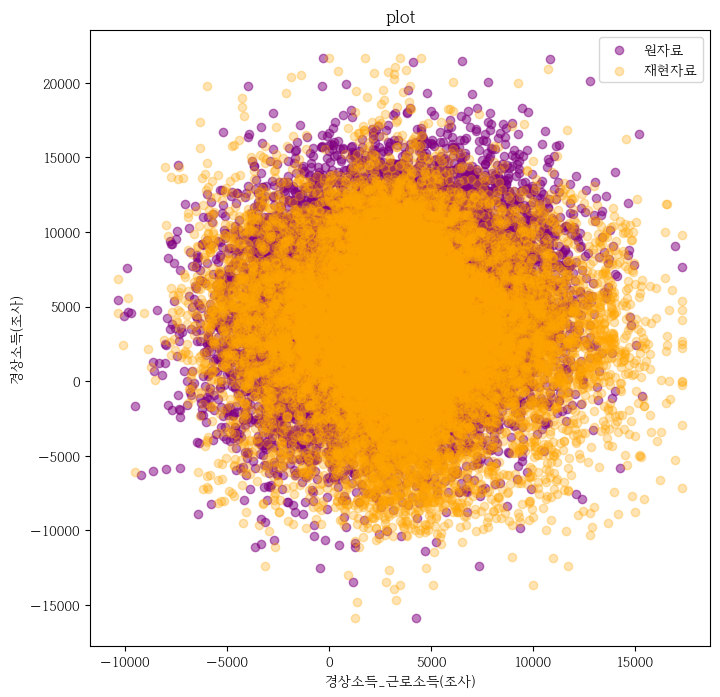

In [153]:
one_by_scatter(all_rho1_mvn[0] , ori_all_rho1_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.3

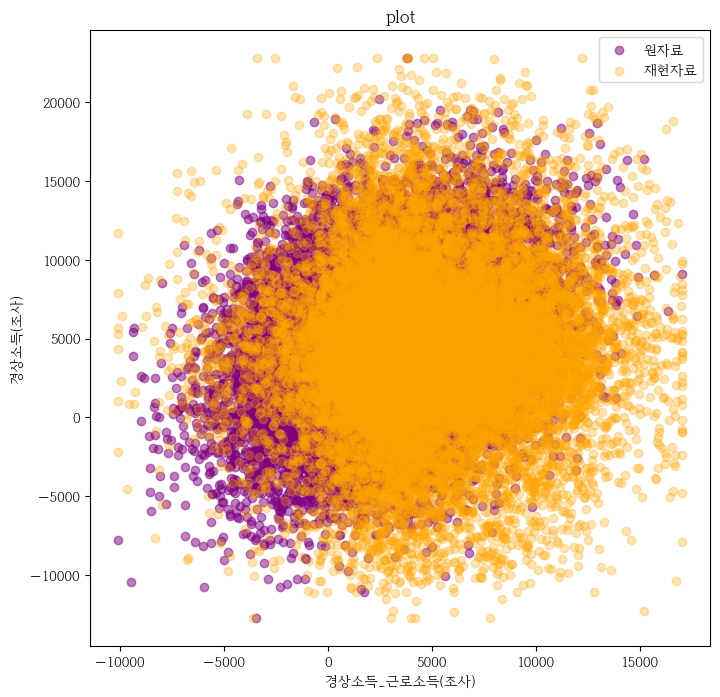

In [154]:
one_by_scatter(all_rho2_mvn[0] , ori_all_rho2_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.5

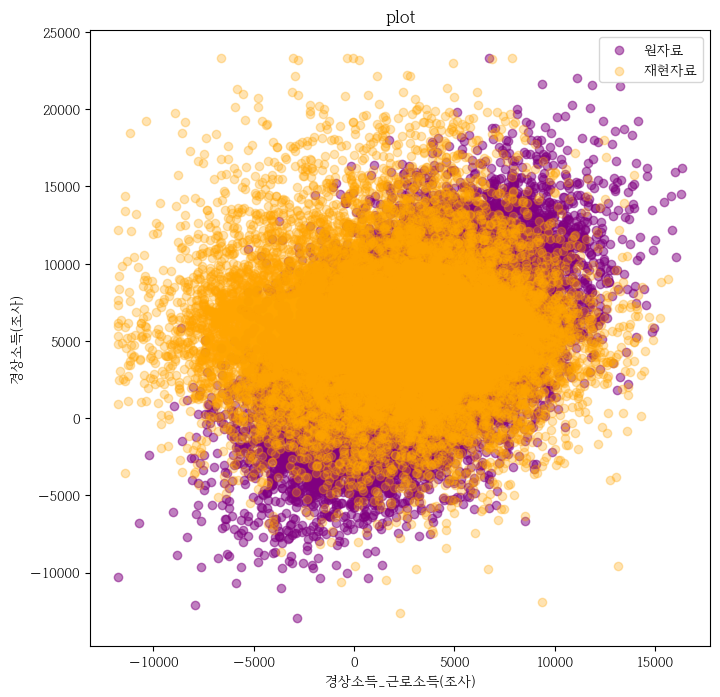

In [155]:
one_by_scatter(all_rho3_mvn[0] , ori_all_rho3_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.7

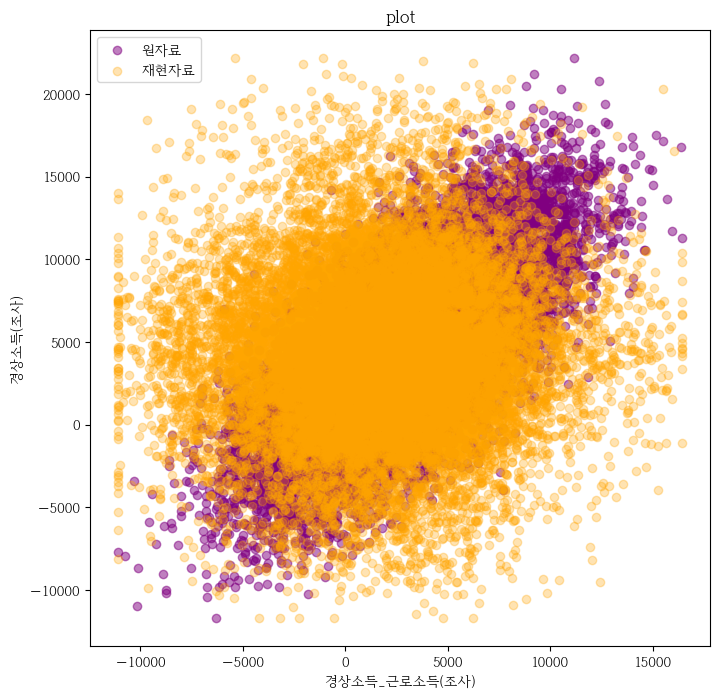

In [156]:
one_by_scatter(all_rho4_mvn[0] , ori_all_rho4_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.9

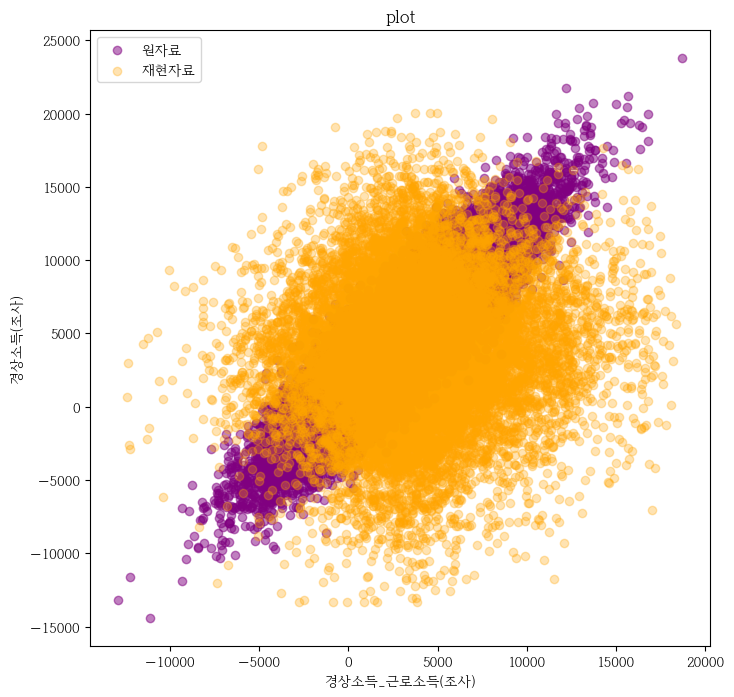

In [157]:
one_by_scatter(all_rho5_mvn[0] , ori_all_rho5_data[0] , '경상소득_근로소득(조사)' , '경상소득(조사)')

### 경상소득이 포함되지 않은 자료에 대한 상관계수 그래프 

두개 같이 그렸을때 히트맵 크기가 일정하게 고정되서 나오지 않음 , 수정 필수

#### $\rho$ = 0.1

Text(0.5, 1.0, '전체재현자료')

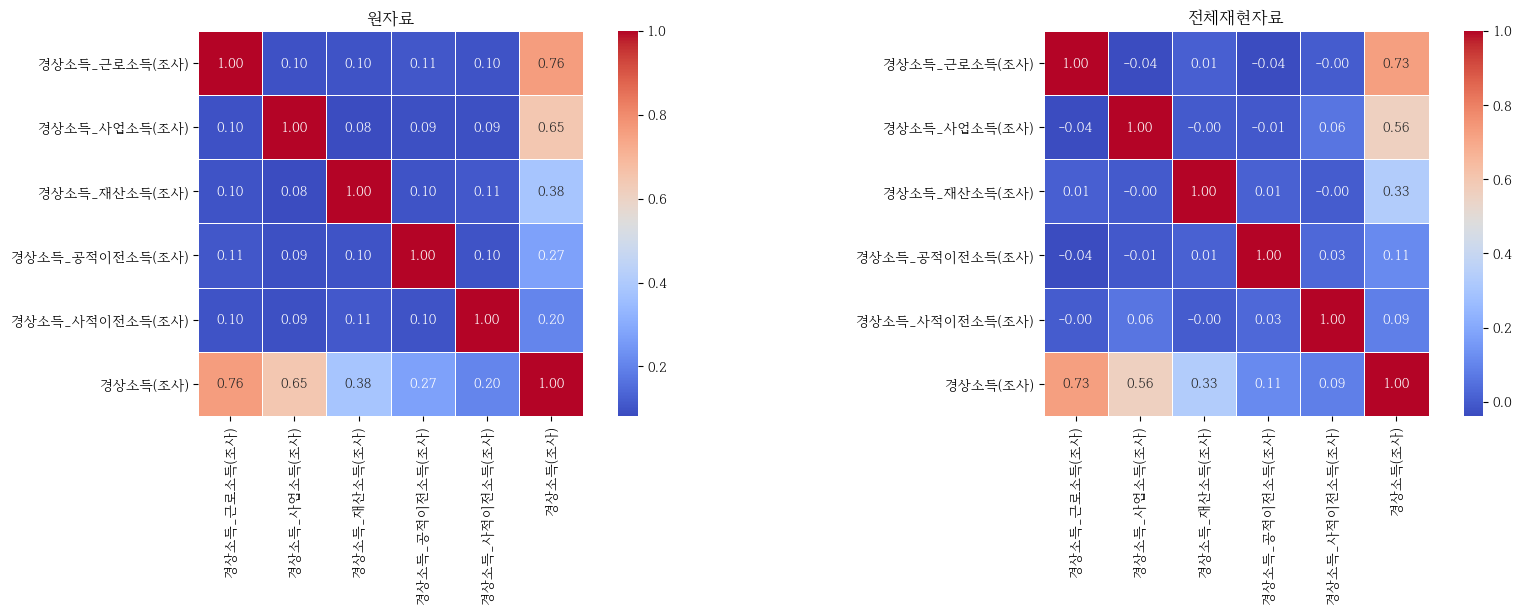

In [615]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (5,5)
sns.heatmap(non_rho1_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(ori_non_rho1_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("전체재현자료")

#### $\rho$ = 0.3

Text(0.5, 1.0, '전체재현자료')

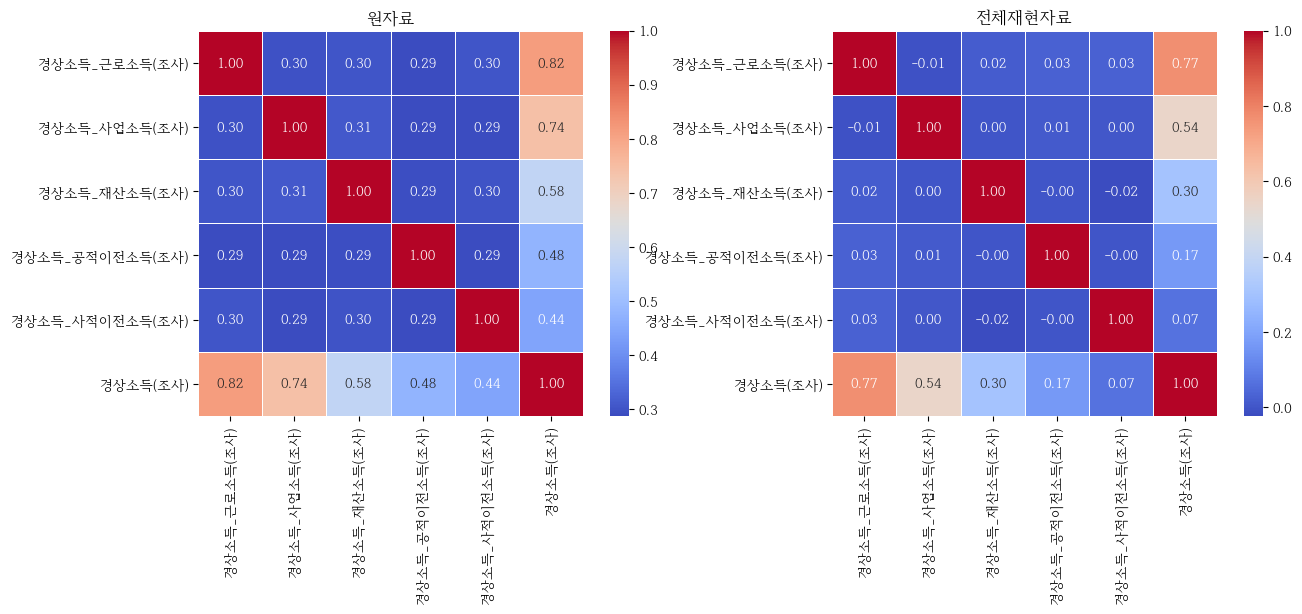

In [619]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (15,15)
sns.heatmap(non_rho2_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(ori_non_rho2_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("전체재현자료")

#### $\rho$ = 0.5

Text(0.5, 1.0, '전체재현자료')

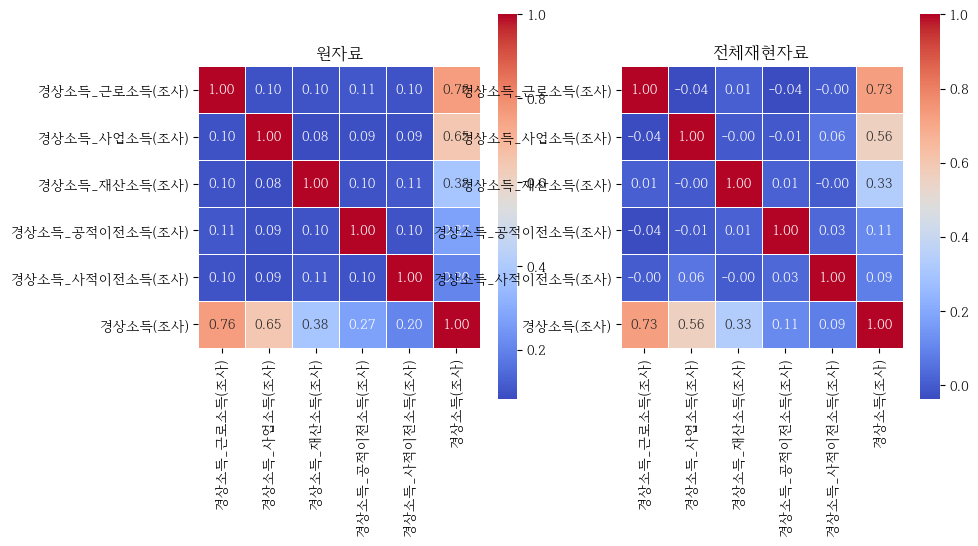

In [655]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (10,5)
sns.heatmap(non_rho1_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(ori_non_rho1_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("전체재현자료")

#### $\rho$ = 0.7

Text(0.5, 1.0, '전체재현자료')

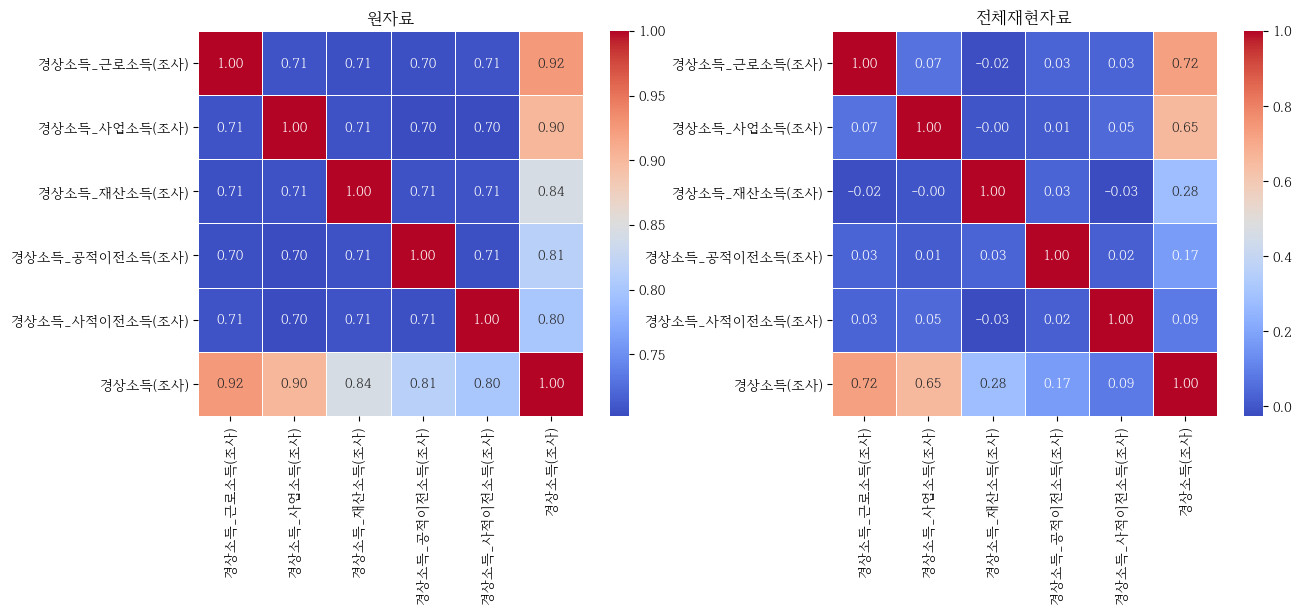

In [651]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (10,5)
sns.heatmap(non_rho4_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(ori_non_rho4_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("전체재현자료")

#### $\rho$ = 0.9

Text(0.5, 1.0, '전체재현자료')

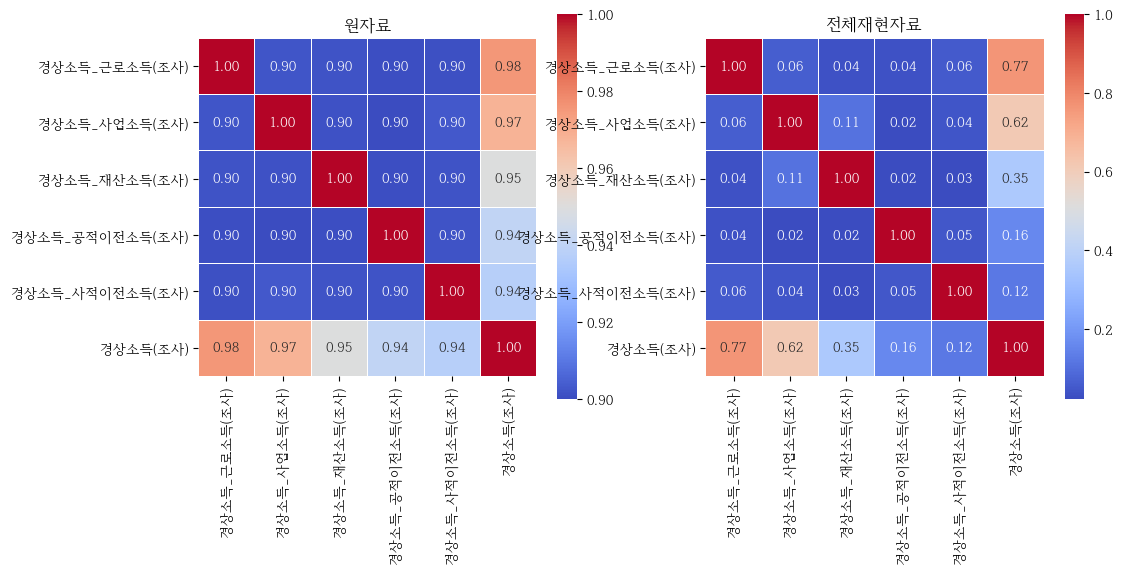

In [658]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (13,5)
sns.heatmap(non_rho5_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(ori_non_rho5_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("전체재현자료")

### 경상소득이 포함된 자료에 대한 상관계수 그래프

#### $\rho$ = 0.1

Text(0.5, 1.0, '전체재현자료')

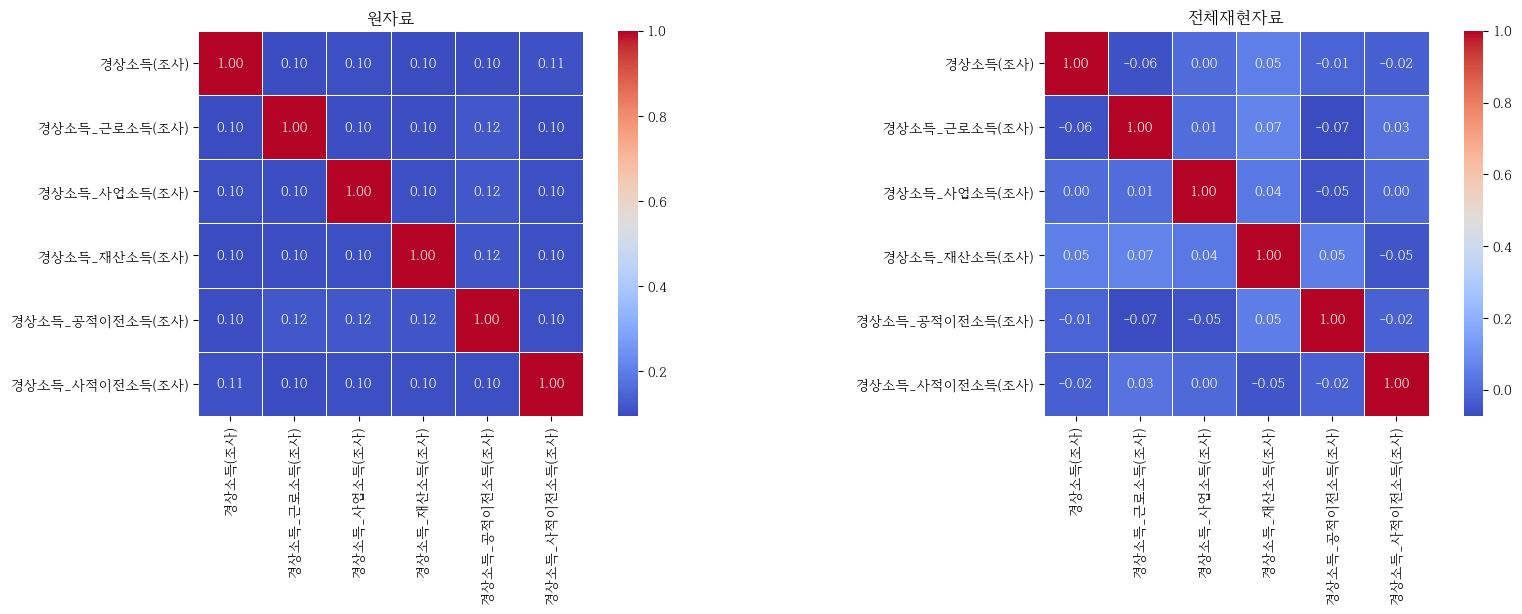

In [568]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (20,15)
sns.heatmap(all_rho1_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(ori_all_rho1_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("전체재현자료")

#### $\rho$ = 0.3

Text(0.5, 1.0, '전체재현자료')

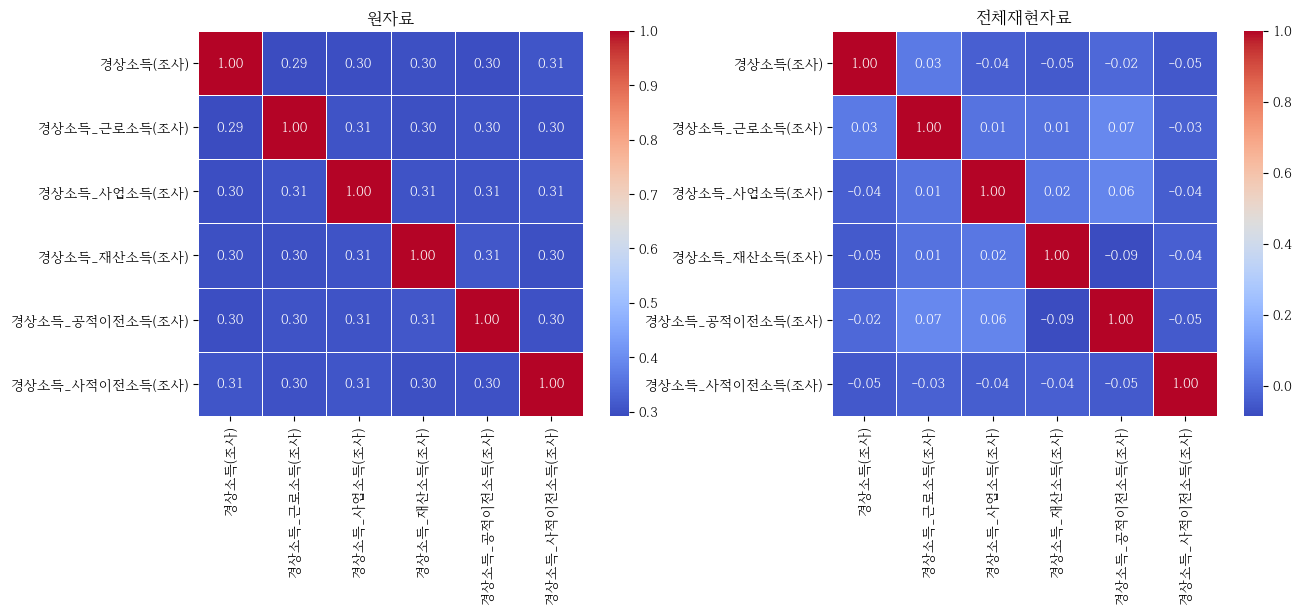

In [567]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (20,5)
sns.heatmap(all_rho2_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(ori_all_rho2_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("전체재현자료")

#### $\rho$ = 0.5

Text(0.5, 1.0, '전체재현자료')

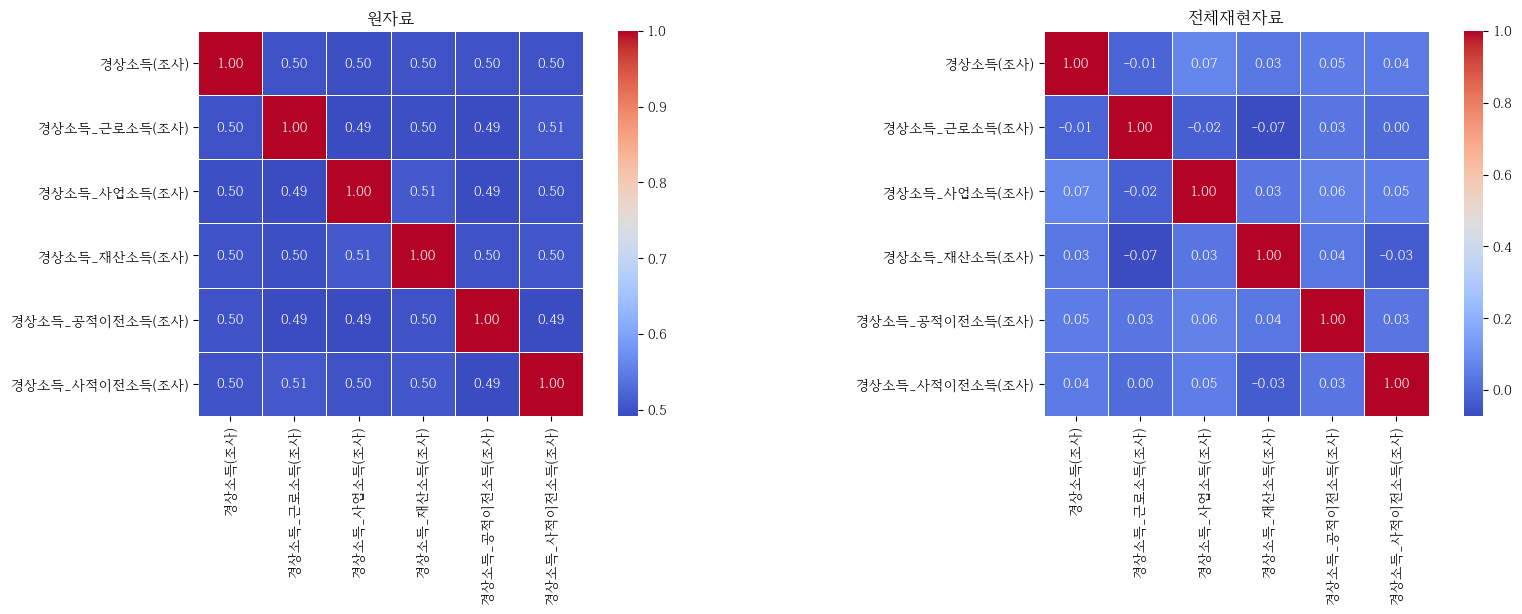

In [570]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (20,5)
sns.heatmap(all_rho3_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(ori_all_rho3_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("전체재현자료")

#### $\rho$ = 0.7

Text(0.5, 1.0, '전체재현자료')

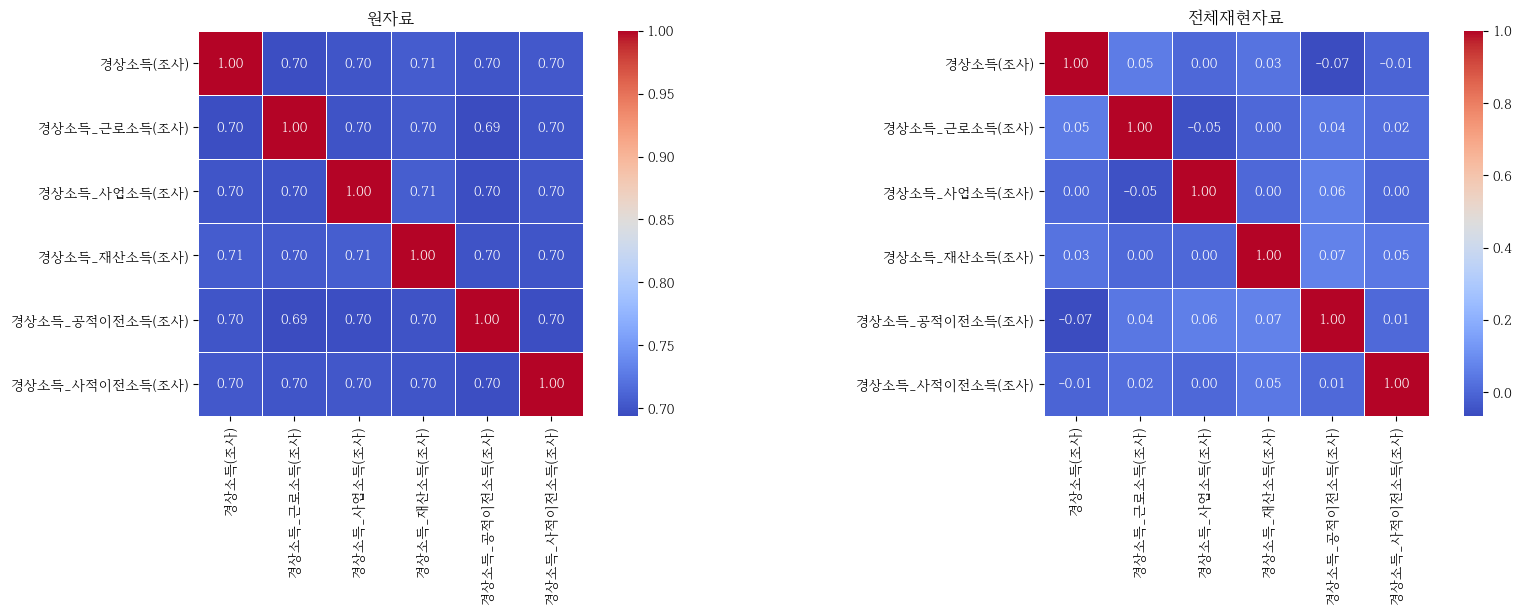

In [571]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (20,5)
sns.heatmap(all_rho4_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(ori_all_rho4_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("전체재현자료")

#### $\rho$ = 0.9

Text(0.5, 1.0, '전체재현자료')

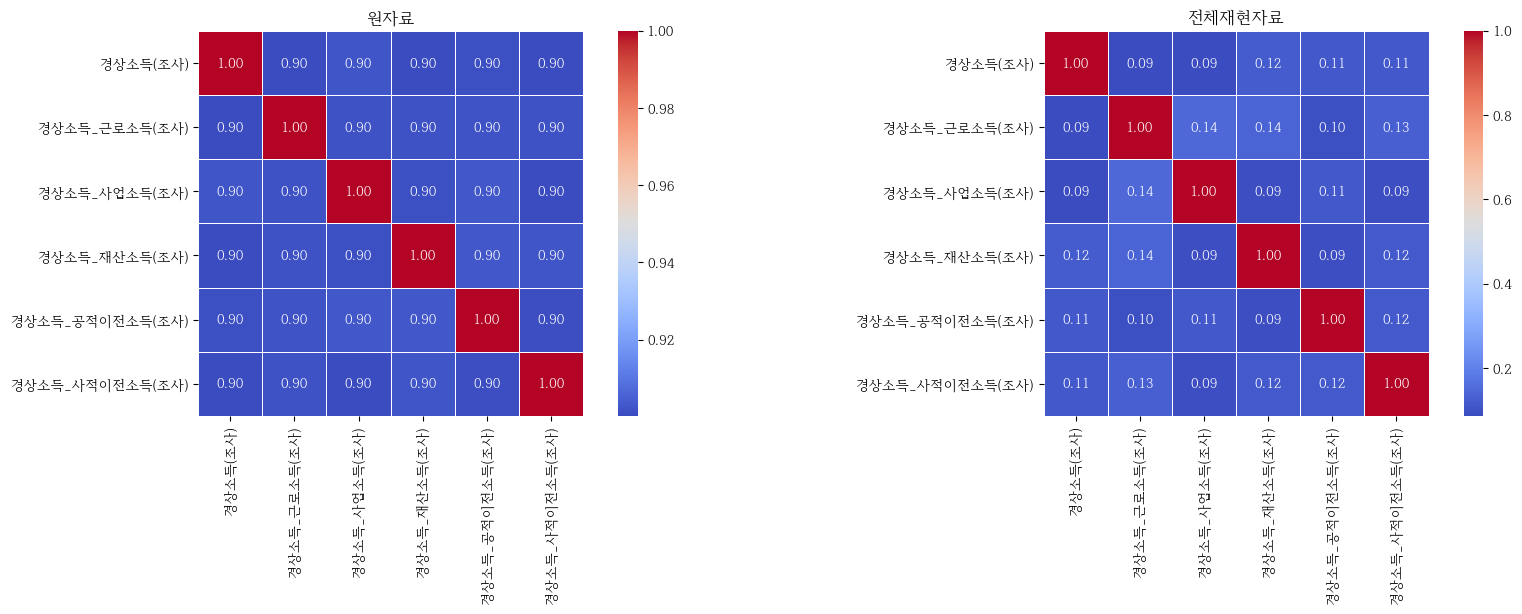

In [121]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (20,5)
sns.heatmap(all_rho5_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(ori_all_rho5_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title("전체재현자료")

### KSComplement ( 원자료 , 재현자료 , 변수 , 반복횟수 ) - 실제자료와 재현자료간의 유사성 측정

SDMetrics 패키지에서 KSComplements라는 함수를 이용할 것인데, 원리는 콜모고로프 스미노프 통계량을 이용한 척도입니다.  
이표본 콜모고로프 스미노프 테스트를 이용해서 두 연속형 변수간의  누적분포를 비교하는 원리 

만약 값이 1에 가까우면 유사하다는 뜻이고 0에 가까우면 다르다는 뜻임

In [123]:
def KSComplements(oridata , synthetic_data , variable , iteration) : 
    
    KSComplement_Result = []       

    for i in range(iteration) : 
        KSComplement_Result.append(
            KSComplement.compute(
                real_data = oridata[i][variable],
                synthetic_data = synthetic_data[i][variable]))
        
    return KSComplement_Result 

In [266]:
KS1 = KSComplements(non_rho1_mvn , ori_non_rho1_data , '경상소득(조사)' , 500)
KS2 = KSComplements(non_rho2_mvn , ori_non_rho2_data , '경상소득(조사)' , 500)
KS3 = KSComplements(non_rho3_mvn , ori_non_rho3_data , '경상소득(조사)' , 500)
KS4 = KSComplements(non_rho4_mvn , ori_non_rho4_data , '경상소득(조사)' , 500)
KS5 = KSComplements(non_rho5_mvn , ori_non_rho5_data , '경상소득(조사)' , 500)

In [124]:
AKS1 = KSComplements(all_rho1_mvn , ori_all_rho1_data , '경상소득(조사)' , 500)
AKS2 = KSComplements(all_rho2_mvn , ori_all_rho2_data , '경상소득(조사)' , 500)
AKS3 = KSComplements(all_rho3_mvn , ori_all_rho3_data , '경상소득(조사)' , 500)
AKS4 = KSComplements(all_rho4_mvn , ori_all_rho4_data , '경상소득(조사)' , 500)
AKS5 = KSComplements(all_rho5_mvn , ori_all_rho5_data , '경상소득(조사)' , 500)

In [125]:
def calculate_statistics(data):
    results = {
        'mean': np.array(np.mean(data)),
        'std': np.array(np.std(data))}
    return results

In [126]:
def measure_dataframe(data1 , data2 , data3 , data4 ,data5):
    
    result = np.array([[np.mean(data1) , np.std(data1)] , [np.mean(data2) , np.std(data2)] , [np.mean(data3) , np.std(data3)] , [np.mean(data4) , np.std(data4)] , [np.mean(data5) , np.std(data5)]])
    frame = pd.DataFrame(result)
    frame.columns = ["척도의 평균" , "척도의 표준편차"]
    frame.index = ['0.1','0.3','0.5','0.7','0.9']
    
    return pd.DataFrame(frame )


경상소득(조사) 미포함

In [291]:
measure_dataframe(KS1 , KS2 , KS3 , KS4 , KS5)

척도의 평균  척도의 표준편차
0.1  0.917108  0.047154
0.3  0.895337  0.043130
0.5  0.874182  0.037028
0.7  0.856234  0.033291
0.9  0.834592  0.039140

경상소득(조사) 포함

In [127]:
measure_dataframe(AKS1 , AKS2 , AKS3 , AKS4 , AKS5)

척도의 평균  척도의 표준편차
0.1  0.891045  0.055641
0.3  0.896473  0.054806
0.5  0.899099  0.048950
0.7  0.904751  0.049146
0.9  0.905394  0.049626

### CorrelationSimilarity ( 원자료 , 재현자료 , 변수1 , 변수2 , 피어슨 OR 스피어만 , 반복횟수 ) - 상관관계 측정 및 유사성 계산

In [128]:
def CorrelationSimilaritys(oridata , synthetic_data , variable1 , variable2 , method , iteration) : 
    
    CorrelationSimilarity_Result = [] 

    for i in range(iteration) : 
        CorrelationSimilarity_Result.append(
            CorrelationSimilarity.compute(
                real_data = oridata[i][[variable1 , variable2]],
                synthetic_data = synthetic_data[i][[variable1 , variable2]],
                coefficient = method))
        
    return CorrelationSimilarity_Result 

In [267]:
CS1 = CorrelationSimilaritys(non_rho1_mvn , ori_non_rho1_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
CS2 = CorrelationSimilaritys(non_rho2_mvn , ori_non_rho2_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
CS3 = CorrelationSimilaritys(non_rho3_mvn , ori_non_rho3_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
CS4 = CorrelationSimilaritys(non_rho4_mvn , ori_non_rho4_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
CS5 = CorrelationSimilaritys(non_rho5_mvn , ori_non_rho5_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)

In [129]:
ACS1 = CorrelationSimilaritys(all_rho1_mvn , ori_all_rho1_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
ACS2 = CorrelationSimilaritys(all_rho2_mvn , ori_all_rho2_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
ACS3 = CorrelationSimilaritys(all_rho3_mvn , ori_all_rho3_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
ACS4 = CorrelationSimilaritys(all_rho4_mvn , ori_all_rho4_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
ACS5 = CorrelationSimilaritys(all_rho5_mvn , ori_all_rho5_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)

경상소득(조사) 미포함

In [294]:
measure_dataframe(CS1 , CS2 , CS3 , CS4 , CS5)

척도의 평균  척도의 표준편차
0.1  0.952622  0.018925
0.3  0.852896  0.018634
0.5  0.755491  0.017239
0.7  0.660181  0.015172
0.9  0.579538  0.016163

경상소득(조사) 포함

In [130]:
measure_dataframe(ACS1 , ACS2 , ACS3 , ACS4 , ACS5)

척도의 평균  척도의 표준편차
0.1  0.951780  0.022480
0.3  0.852996  0.022180
0.5  0.755169  0.021505
0.7  0.660656  0.020363
0.9  0.597116  0.026818

### RangeCoverage ( 원자료 , 재현자료 , 변수 , 반복횟수 ) - 재현자료의 열이 실제 데이터의 열의 모든범위의 값을 포함하는지 여부

In [131]:
def RangeCoverages(oridata , synthetic_data , variable , iteration) : 
    
    RangeCoverage_Result = [] 
    
    for i in range(iteration) :
        RangeCoverage_Result.append(
            RangeCoverage.compute(
                real_data = oridata[i][variable],
                synthetic_data = synthetic_data[i][variable]))
        
    return RangeCoverage_Result
    

In [268]:
RC1 = RangeCoverages(non_rho1_mvn , ori_non_rho1_data , '경상소득(조사)' , 500)
RC2 = RangeCoverages(non_rho2_mvn , ori_non_rho2_data , '경상소득(조사)' , 500)
RC3 = RangeCoverages(non_rho3_mvn , ori_non_rho3_data , '경상소득(조사)' , 500)
RC4 = RangeCoverages(non_rho4_mvn , ori_non_rho4_data , '경상소득(조사)' , 500)
RC5 = RangeCoverages(non_rho5_mvn , ori_non_rho5_data , '경상소득(조사)' , 500)

In [132]:
ARC1 = RangeCoverages(all_rho1_mvn , ori_all_rho1_data , '경상소득(조사)' , 500)
ARC2 = RangeCoverages(all_rho2_mvn , ori_all_rho2_data , '경상소득(조사)' , 500)
ARC3 = RangeCoverages(all_rho3_mvn , ori_all_rho3_data , '경상소득(조사)' , 500)
ARC4 = RangeCoverages(all_rho4_mvn , ori_all_rho4_data , '경상소득(조사)' , 500)
ARC5 = RangeCoverages(all_rho5_mvn , ori_all_rho5_data , '경상소득(조사)' , 500)

경상소득(조사) 미포함

In [292]:
measure_dataframe(RC1 , RC2 , RC3 , RC4 , RC5)

척도의 평균  척도의 표준편차
0.1  0.952047  0.050212
0.3  0.851476  0.065991
0.5  0.753470  0.064110
0.7  0.677181  0.057743
0.9  0.629172  0.055754

경상소득(조사) 포함

In [133]:
measure_dataframe(ARC1 , ARC2 , ARC3 , ARC4 , ARC5)

척도의 평균  척도의 표준편차
0.1  0.988032  0.024359
0.3  0.985131  0.026089
0.5  0.983511  0.028844
0.7  0.981383  0.029092
0.9  0.952501  0.044831

### BoundaryAdherence ( 원자료 , 재현자료 , 변수 , 반복횟수) - 재현자료가 실제자료의 최소값과 최대값을 준수하는지 여부를 결정

In [134]:
def BoundaryAdherences(oridata , synthetic_data , variable , iteration): 
    
    BoundaryAdherence_Result = []
    
    for i in range(iteration) : 
        BoundaryAdherence_Result.append(
            BoundaryAdherence.compute(
                real_data = oridata[i][variable],
                synthetic_data = synthetic_data[i][variable]))
        
    return BoundaryAdherence_Result

In [269]:
BA1 = BoundaryAdherences(non_rho1_mvn , ori_non_rho1_data , '경상소득(조사)' , 500)
BA2 = BoundaryAdherences(non_rho2_mvn , ori_non_rho2_data , '경상소득(조사)' , 500)
BA3 = BoundaryAdherences(non_rho3_mvn , ori_non_rho3_data , '경상소득(조사)' , 500)
BA4 = BoundaryAdherences(non_rho4_mvn , ori_non_rho4_data , '경상소득(조사)' , 500)
BA5 = BoundaryAdherences(non_rho5_mvn , ori_non_rho5_data , '경상소득(조사)' , 500)

In [135]:
ABA1 = BoundaryAdherences(all_rho1_mvn , ori_all_rho1_data , '경상소득(조사)' , 500)
ABA2 = BoundaryAdherences(all_rho2_mvn , ori_all_rho2_data , '경상소득(조사)' , 500)
ABA3 = BoundaryAdherences(all_rho3_mvn , ori_all_rho3_data , '경상소득(조사)' , 500)
ABA4 = BoundaryAdherences(all_rho4_mvn , ori_all_rho4_data , '경상소득(조사)' , 500)
ABA5 = BoundaryAdherences(all_rho5_mvn , ori_all_rho5_data , '경상소득(조사)' , 500)

경상소득(조사) 미포함

In [293]:
measure_dataframe(BA1 , BA2 , BA3 , BA4 , BA5)

척도의 평균  척도의 표준편차
0.1  0.999757  0.000362
0.3  0.999987  0.000033
0.5  0.999999  0.000008
0.7  1.000000  0.000000
0.9  1.000000  0.000000

경상소득(조사) 포함

In [136]:
measure_dataframe(ABA1 , ABA2 , ABA3 , ABA4 , ABA5)

척도의 평균  척도의 표준편차
0.1  1.000000  0.000000
0.3  1.000000  0.000000
0.5  1.000000  0.000000
0.7  1.000000  0.000000
0.9  0.999547  0.000728

### KL DIVERGENCE ( 원자료 , 재현자료 , 변수 , 반복횟수 ) 

In [137]:
"""ColumnPair metrics based on Kullback–Leibler Divergence."""

import numpy as np
import pandas as pd
from scipy.special import kl_div

from sdmetrics.column_pairs.base import ColumnPairsMetric
from sdmetrics.goal import Goal
from sdmetrics.utils import get_frequencies


class ContinuousKLDivergence(ColumnPairsMetric):
    """Continuous Kullback–Leibler Divergence based metric.

    This approximates the KL divergence by binning the continuous values
    to turn them into categorical values and then computing the relative
    entropy. Afterwards normalizes the value applying ``1 / (1 + KLD)``.

    Attributes:
        name (str):
            Name to use when reports about this metric are printed.
        goal (sdmetrics.goal.Goal):
            The goal of this metric.
        min_value (Union[float, tuple[float]]):
            Minimum value or values that this metric can take.
        max_value (Union[float, tuple[float]]):
            Maximum value or values that this metric can take.
    """

    name = 'Continuous Kullback–Leibler Divergence'
    goal = Goal.MAXIMIZE
    min_value = 0.0
    max_value = 1.0

    @staticmethod
    def compute(real_data, synthetic_data):
        """Compare two pairs of continuous columns using Kullback–Leibler Divergence.

        Args:
            real_data (pandas.DataFrame):
                The values from the real dataset, passed as pandas.DataFrame
                with 2 columns.
            synthetic_data (pandas.DataFrame):
                The values from the synthetic dataset, passed as a
                pandas.DataFrame with 2 columns.

        Returns:
            Union[float, tuple[float]]:
                Metric output.
        """
        real_data[pd.isna(real_data)] = 0.0
        synthetic_data[pd.isna(synthetic_data)] = 0.0
        column1 = '경상소득_근로소득(조사)'
        column2 = '경상소득(조사)'
        
        real, xedges, yedges = np.histogram2d(real_data[column1], real_data[column2])
        synthetic, _, _ = np.histogram2d(
            synthetic_data[column1], synthetic_data[column2], bins=[xedges, yedges])

        f_obs, f_exp = synthetic.flatten() + 1e-5, real.flatten() + 1e-5
        f_obs, f_exp = f_obs / np.sum(f_obs), f_exp / np.sum(f_exp)

        return 1 / (1 + np.sum(kl_div(f_obs, f_exp)))

    @classmethod
    def normalize(cls, raw_score):
        """Return the `raw_score` as is, since it is already normalized.

        Args:
            raw_score (float):
                The value of the metric from `compute`.

        Returns:
            float:
                The normalized value of the metric
        """
        return super().normalize(raw_score)

In [138]:
continous_k1_metric = ContinuousKLDivergence()

In [139]:
def KLD(oridata, synthetic_data , iteration) : # 이용 변수 : 경상소득(조사) , 경상소득_근로소득(조사)
    
    KLD_Result = [] 
    
    for i in range(iteration) : 
        KLD_Result.append(
            continous_k1_metric.compute(oridata[i] , synthetic_data[i]))
    
    return KLD_Result

In [82]:
KL1 = KLD(non_rho1_mvn ,  ori_non_rho1_data , 500)
KL2 = KLD(non_rho2_mvn ,  ori_non_rho2_data , 500)
KL3 = KLD(non_rho3_mvn ,  ori_non_rho3_data , 500)
KL4 = KLD(non_rho4_mvn ,  ori_non_rho4_data , 500)
KL5 = KLD(non_rho5_mvn ,  ori_non_rho5_data , 500)

In [140]:
AKL1 = KLD(all_rho1_mvn , ori_all_rho1_data , 500)
AKL2 = KLD(all_rho2_mvn , ori_all_rho2_data , 500)
AKL3 = KLD(all_rho3_mvn , ori_all_rho3_data , 500)
AKL4 = KLD(all_rho4_mvn , ori_all_rho4_data , 500)
AKL5 = KLD(all_rho5_mvn , ori_all_rho5_data , 500)

경상소득(조사) 미포함

In [83]:
measure_dataframe(KL1 , KL2 , KL3 , KL4 , KL5)

척도의 평균  척도의 표준편차
0.1  0.905912  0.041218
0.3  0.849129  0.044532
0.5  0.743085  0.049905
0.7  0.608961  0.054194
0.9  0.361144  0.048730

경상소득(조사) 포함

In [85]:
measure_dataframe(AKL1 , AKL2 , AKL3 , AKL4 , AKL5)

척도의 평균  척도의 표준편차
0.1  0.838318  0.064780
0.3  0.790239  0.065481
0.5  0.681762  0.073645
0.7  0.497405  0.061370
0.9  0.503131  0.059267

## CAP algorithm

In [420]:
from sdmetrics.single_table import CategoricalCAP

score = CategoricalCAP.compute(
    real_data = non_rho1_mvn[1],
    synthetic_data = ori_non_rho1_data[1],
    key_fields=['경상소득_근로소득(조사)', '경상소득_사업소득(조사)'],
    sensitive_fields=['경상소득(조사)']
)

In [421]:
score

0